## Data Mining / Prospeção de Dados

# Project 1 - Pattern Mining

## Dataset and Tools



In this project you will analyse data from an online Store collected over 4 months (April - July 2014). The folder `data` contains three files that you should use to obtain the dataset to be used in pattern mining. 

The file `store-buys.dat` comprises the buy events of the users over the items. It contains **318.444 sessions**. Each record/line in the file has the following fields (with this order): 

* **Session ID** - the id of the session. In one session there are one or many buying events. Could be represented as an integer number.
* **Timestamp** - the time when the buy occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
* **Item ID** – the unique identifier of item that has been bought. Could be represented as an integer number. 
* **Price** – the price of the item. Could be represented as an integer number.
* **Quantity** – the quantity in this buying.  Could be represented as an integer number.

The file `store-clicks.dat` comprises the clicks of the users over the items. It contains **5.613.499 sessions**.  Each record/line in the file has the following fields (with this order):

* **Session ID** – the id of the session. In one session there are one or many clicks. Could be represented as an integer number.
* **Timestamp** – the time when the click occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
* **Item ID** – the unique identifier of the item that has been clicked. Could be represented as an integer number.
* **Context** – the context of the click. The value "S" indicates a special offer, "0" indicates  a missing value, a number between 1 to 12 indicates a real category identifier,
any other number indicates a brand. E.g. if an item has been clicked in the context of a promotion or special offer then the value will be "S", if the context was a brand i.e BOSCH,
then the value will be an 8-10 digits number. If the item has been clicked under regular category, i.e. sport, then the value will be a number between 1 to 12. 
 
The file `products.csv` comprises the list of products sold by the online store. It contains **46.294 different products** associated with **123 different subcategories**. Each record/line in the file has the following fields:

* **Item ID** - the unique identifier of the item. Could be represented as an integer number. 
* **Product Categories** - the category and subcategories of the item. It is a string containing the category and subcategories of the item. Eg. `appliances.kitchen.juice`


In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[MLxtend](http://rasbt.github.io/mlxtend/)**. When using MLxtend, frequent patterns can either be discovered using `Apriori` and `FP-Growth`.


## 1. Mining Frequent Itemsets and Association Rules


In this first part of the project you should load and preprocess the dataset  in order to compute frequent itemsets and generate association rules considering all the sessions.

**In what follows keep the following question in mind and be creative!**

1. What are the most interesting products?
2. What are the most bought products?
3. Which products are bought together?
4. Can you find associations between the clicked products? 
5. Can you find associations highliting that when people buy a product/set of products also buy other product(s)?
6. Can you find associations highliting that when people click in a product/set of products also buy this product(s)?
7. Can you find relevant associated categories? 

### 1.1. Load and Preprocess Data

 **Product quantities should not be considered.**

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import association_rules,fpgrowth, apriori, fpmax
pd.options.mode.chained_assignment = None
pd.set_option("max_colwidth", 150)

### Load Data

Product data:

In [99]:
Pdata = pd.read_csv("products.csv", names = ['item_id', 'category'])

Bought items data:

In [100]:
Bdata = pd.read_csv("store-buys.dat", names = ["session_id", "timestamp", "item_id", "price", "quantity"])
Bdata.head(5)

,session_id,timestamp,item_id,price,quantity
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1


In [101]:
Bdata.dtypes

session_id     int64
timestamp     object
item_id        int64
price          int64
quantity       int64
dtype: object

Covert timestamp to datetime:

In [102]:
Bdata.timestamp = Bdata.timestamp.astype('datetime64')

Clicked items data:

In [103]:
Cdata = pd.read_csv("store-clicks.dat",  names = ["session_id", "timestamp", "item_id", "context"])
Cdata.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,session_id,timestamp,item_id,context
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


In [104]:
Cdata.dtypes

session_id     int64
timestamp     object
item_id        int64
context       object
dtype: object

Convert dates and remove "context"

In [105]:
Cdata.timestamp = Cdata.timestamp.astype('datetime64')
Cdata.drop('context',inplace=True, axis = 1)

### Preprocess data

#### Bought data

In [106]:
Bitems = Bdata[['item_id','session_id']]

A normal merge between Bitems and Pdata runs into memory problems so the workaround we found is to use Pdata as an index table

In [107]:
#first drop duplicates
Pdata.drop_duplicates(inplace=True)

In [108]:
#set index to item_id
Pdata.set_index('item_id',inplace=True)

We also add 'b_' to the beggining of the category. This will later be used to differentiate items that were bought vs items that were clicked

In [109]:
Pdata['b_category'] = Pdata.category.apply(lambda x: 'b_' +x)

In [110]:
Bitems["category"] = Bitems["item_id"].apply(lambda x: Pdata.b_category.loc[x])
Bitems

,item_id,session_id,category
0,214537888,420374,b_ computers.network.router
1,214537850,420374,b_ computers.network.router
2,214535653,281626,b_ kids.dolls
3,214530572,420368,b_ electronics.audio.microphone
4,214835025,420368,b_ appliances.kitchen.toster
...,...,...,...
679484,214665277,6926714,b_ electronics.calculator
679485,214567057,6645086,b_ computers.notebook
679486,214708044,6740437,b_ appliances.kitchen.fryer
679487,214848986,6926707,b_ appliances.steam_cleaner


In [111]:
Bitems.drop('item_id',axis=1, inplace=True)

We group by session id and put the categories into lists. this is necessary

In [112]:
Bitems = Bitems.groupby('session_id')['category'].apply(list).reset_index(name='item_names')
Bitems

,session_id,item_names
0,11,"[b_ appliances.kitchen.blender, b_ appliances.kitchen.blender]"
1,12,[b_ accessories.bag]
2,21,"[b_ kids.skates, b_ electronics.clocks]"
3,33,"[b_ appliances.environment.fan, b_ computers.peripherals.printer, b_ appliances.kitchen.meat_grinder, b_ appliances.environment.fan, b_ appliances..."
4,46,"[b_ electronics.video.tv, b_ electronics.video.tv]"
...,...,...
318439,7016809,"[b_ appliances.steam_cleaner, b_ construction.tools.drill, b_ furniture.universal.light]"
318440,7016822,"[b_ construction.tools.drill, b_ construction.tools.drill]"
318441,7016833,"[b_ construction.tools.drill, b_ construction.tools.drill, b_ appliances.kitchen.grill]"
318442,7016853,"[b_ appliances.steam_cleaner, b_ appliances.steam_cleaner, b_ sport.tennis, b_ appliances.steam_cleaner]"


#### Clicked data

The same steps are repeated

In [113]:
Pdata['c_category'] = Pdata.category.apply(lambda x: 'c_' +x)

In [114]:
Citems = Cdata[['item_id','session_id']]
Citems["category"] = Citems["item_id"].apply(lambda x: Pdata.c_category.loc[x])
Citems.drop('item_id',axis=1, inplace=True)
Citems = Citems.groupby('session_id')['category'].apply(list).reset_index(name='item_names')
Citems.head(5)

,session_id,item_names
0,1,"[c_ electronics.tablet, c_ electronics.tablet, c_ electronics.tablet, c_ electronics.audio.headphone]"
1,2,"[c_ furniture.kitchen.table, c_ furniture.kitchen.table, c_ electronics.smartphone, c_ appliances.kitchen.refrigerators, c_ appliances.kitchen.ref..."
2,3,"[c_ electronics.video.tv, c_ computers.components.cpu, c_ computers.notebook]"
3,4,"[c_ computers.peripherals.monitor, c_ computers.peripherals.printer]"
4,6,"[c_ appliances.kitchen.kettle, c_ computers.components.memory]"


#### Clicked and bought items

The two datasets are merged on session_id and the values are concatenated.

In [115]:
BCitems = pd.merge(Citems,Bitems, on='session_id')
BCitems['item_names'] = BCitems['item_names_x'] + BCitems['item_names_y']
BCitems.drop(['item_names_x','item_names_y'], inplace=True,axis=1)

### Encode data

Bought items data:

In [28]:
from mlxtend.preprocessing import TransactionEncoder
encoder = TransactionEncoder()

convert to sparse matrix:

In [29]:
Bitems_list = Bitems.item_names.to_list()
Btrans = encoder.fit(Bitems_list).transform(Bitems_list, sparse=True)
Btrans_df = pd.DataFrame.sparse.from_spmatrix(Btrans, columns=encoder.columns_)
Btrans_df

,b_ accessories.bag,b_ accessories.umbrella,b_ apparel.costume,b_ apparel.glove,b_ apparel.shirt,b_ apparel.shoes,b_ apparel.sock,b_ apparel.trousers,b_ apparel.tshirt,b_ appliances.environment.air_conditioner,b_ appliances.environment.air_heater,b_ appliances.environment.climate,b_ appliances.environment.fan,b_ appliances.environment.vacuum,b_ appliances.environment.water_heater,b_ appliances.iron,b_ appliances.ironing_board,b_ appliances.kitchen.blender,b_ appliances.kitchen.coffee_grinder,b_ appliances.kitchen.coffee_machine,b_ appliances.kitchen.dishwasher,b_ appliances.kitchen.fryer,b_ appliances.kitchen.grill,b_ appliances.kitchen.hood,b_ appliances.kitchen.juicer,b_ appliances.kitchen.kettle,b_ appliances.kitchen.meat_grinder,b_ appliances.kitchen.microwave,b_ appliances.kitchen.mixer,b_ appliances.kitchen.oven,b_ appliances.kitchen.refrigerators,b_ appliances.kitchen.steam_cooker,b_ appliances.kitchen.toster,b_ appliances.kitchen.washer,b_ appliances.personal.hair_cutter,b_ appliances.personal.massager,b_ appliances.personal.scales,b_ appliances.sewing_machine,b_ appliances.steam_cleaner,b_ auto.accessories.alarm,...,b_ electronics.audio.subwoofer,b_ electronics.calculator,b_ electronics.camera.photo,b_ electronics.camera.video,b_ electronics.clocks,b_ electronics.smartphone,b_ electronics.tablet,b_ electronics.telephone,b_ electronics.video.projector,b_ electronics.video.tv,b_ furniture.bathroom.bath,b_ furniture.bathroom.toilet,b_ furniture.bedroom.bed,b_ furniture.bedroom.blanket,b_ furniture.bedroom.pillow,b_ furniture.kitchen.chair,b_ furniture.kitchen.table,b_ furniture.living_room.cabinet,b_ furniture.living_room.chair,b_ furniture.living_room.shelving,b_ furniture.living_room.sofa,b_ furniture.universal.light,b_ kids.bottles,b_ kids.carriage,b_ kids.dolls,b_ kids.fmcg.diapers,b_ kids.skates,b_ kids.swing,b_ kids.toys,b_ medicine.tools.tonometer,b_ sport.bicycle,b_ sport.diving,b_ sport.ski,b_ sport.snowboard,b_ sport.tennis,b_ sport.trainer,b_ stationery.battery,b_ stationery.cartrige,b_ stationery.paper,b_ stationery.stapler
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318440,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318441,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318442,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Clicked items data:

In [31]:
Citems_list = Citems.item_names.to_list()
Ctrans = encoder.fit(Citems_list).transform(Citems_list, sparse=True)
Ctrans_df = pd.DataFrame.sparse.from_spmatrix(Ctrans, columns=encoder.columns_)
Ctrans_df

,c_ accessories.bag,c_ accessories.umbrella,c_ apparel.costume,c_ apparel.glove,c_ apparel.shirt,c_ apparel.shoes,c_ apparel.sock,c_ apparel.trousers,c_ apparel.tshirt,c_ appliances.environment.air_conditioner,c_ appliances.environment.air_heater,c_ appliances.environment.climate,c_ appliances.environment.fan,c_ appliances.environment.vacuum,c_ appliances.environment.water_heater,c_ appliances.iron,c_ appliances.ironing_board,c_ appliances.kitchen.blender,c_ appliances.kitchen.coffee_grinder,c_ appliances.kitchen.coffee_machine,c_ appliances.kitchen.dishwasher,c_ appliances.kitchen.fryer,c_ appliances.kitchen.grill,c_ appliances.kitchen.hood,c_ appliances.kitchen.juicer,c_ appliances.kitchen.kettle,c_ appliances.kitchen.meat_grinder,c_ appliances.kitchen.microwave,c_ appliances.kitchen.mixer,c_ appliances.kitchen.oven,c_ appliances.kitchen.refrigerators,c_ appliances.kitchen.steam_cooker,c_ appliances.kitchen.toster,c_ appliances.kitchen.washer,c_ appliances.personal.hair_cutter,c_ appliances.personal.massager,c_ appliances.personal.scales,c_ appliances.sewing_machine,c_ appliances.steam_cleaner,c_ auto.accessories.alarm,...,c_ electronics.audio.subwoofer,c_ electronics.calculator,c_ electronics.camera.photo,c_ electronics.camera.video,c_ electronics.clocks,c_ electronics.smartphone,c_ electronics.tablet,c_ electronics.telephone,c_ electronics.video.projector,c_ electronics.video.tv,c_ furniture.bathroom.bath,c_ furniture.bathroom.toilet,c_ furniture.bedroom.bed,c_ furniture.bedroom.blanket,c_ furniture.bedroom.pillow,c_ furniture.kitchen.chair,c_ furniture.kitchen.table,c_ furniture.living_room.cabinet,c_ furniture.living_room.chair,c_ furniture.living_room.shelving,c_ furniture.living_room.sofa,c_ furniture.universal.light,c_ kids.bottles,c_ kids.carriage,c_ kids.dolls,c_ kids.fmcg.diapers,c_ kids.skates,c_ kids.swing,c_ kids.toys,c_ medicine.tools.tonometer,c_ sport.bicycle,c_ sport.diving,c_ sport.ski,c_ sport.snowboard,c_ sport.tennis,c_ sport.trainer,c_ stationery.battery,c_ stationery.cartrige,c_ stationery.paper,c_ stationery.stapler
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5613494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5613495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5613496,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5613497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Clicked and bought data

In [32]:
BCitems_list = BCitems.item_names.to_list()
BCtrans = encoder.fit(BCitems_list).transform(BCitems_list, sparse=True)
BCtrans_df = pd.DataFrame.sparse.from_spmatrix(BCtrans, columns=encoder.columns_)
BCtrans_df

,b_ accessories.bag,b_ accessories.umbrella,b_ apparel.costume,b_ apparel.glove,b_ apparel.shirt,b_ apparel.shoes,b_ apparel.sock,b_ apparel.trousers,b_ apparel.tshirt,b_ appliances.environment.air_conditioner,b_ appliances.environment.air_heater,b_ appliances.environment.climate,b_ appliances.environment.fan,b_ appliances.environment.vacuum,b_ appliances.environment.water_heater,b_ appliances.iron,b_ appliances.ironing_board,b_ appliances.kitchen.blender,b_ appliances.kitchen.coffee_grinder,b_ appliances.kitchen.coffee_machine,b_ appliances.kitchen.dishwasher,b_ appliances.kitchen.fryer,b_ appliances.kitchen.grill,b_ appliances.kitchen.hood,b_ appliances.kitchen.juicer,b_ appliances.kitchen.kettle,b_ appliances.kitchen.meat_grinder,b_ appliances.kitchen.microwave,b_ appliances.kitchen.mixer,b_ appliances.kitchen.oven,b_ appliances.kitchen.refrigerators,b_ appliances.kitchen.steam_cooker,b_ appliances.kitchen.toster,b_ appliances.kitchen.washer,b_ appliances.personal.hair_cutter,b_ appliances.personal.massager,b_ appliances.personal.scales,b_ appliances.sewing_machine,b_ appliances.steam_cleaner,b_ auto.accessories.alarm,...,c_ electronics.audio.subwoofer,c_ electronics.calculator,c_ electronics.camera.photo,c_ electronics.camera.video,c_ electronics.clocks,c_ electronics.smartphone,c_ electronics.tablet,c_ electronics.telephone,c_ electronics.video.projector,c_ electronics.video.tv,c_ furniture.bathroom.bath,c_ furniture.bathroom.toilet,c_ furniture.bedroom.bed,c_ furniture.bedroom.blanket,c_ furniture.bedroom.pillow,c_ furniture.kitchen.chair,c_ furniture.kitchen.table,c_ furniture.living_room.cabinet,c_ furniture.living_room.chair,c_ furniture.living_room.shelving,c_ furniture.living_room.sofa,c_ furniture.universal.light,c_ kids.bottles,c_ kids.carriage,c_ kids.dolls,c_ kids.fmcg.diapers,c_ kids.skates,c_ kids.swing,c_ kids.toys,c_ medicine.tools.tonometer,c_ sport.bicycle,c_ sport.diving,c_ sport.ski,c_ sport.snowboard,c_ sport.tennis,c_ sport.trainer,c_ stationery.battery,c_ stationery.cartrige,c_ stationery.paper,c_ stationery.stapler
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318440,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318441,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318442,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### 1.2. Compute Frequent Itemsets

### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support of X%. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.
* Change X and Y when it makes sense and discuss the results.

Since there are 123 categories (a high number) and 318 000+ rows, as showed in the previous section, FPgrowth will surely outperform apriori.

#### Bought items



The reason why exploring X and Y is important is because if we choose a high minimum support we'll only get item sets that have a low number of elements. However if we choose a low minimum support to increase the length of the itemsets we get, we'll also get many item sets that have a low number of elements. We need to keep in mind that a certain support is good for selecting item sets with a specific number of elements since frequent 3-itemsets are more rare than 2-itemsets. To illustrate this, instead of fiddling with X and Y let's plot the distribution of the number of itemsets with high, medium and low support.

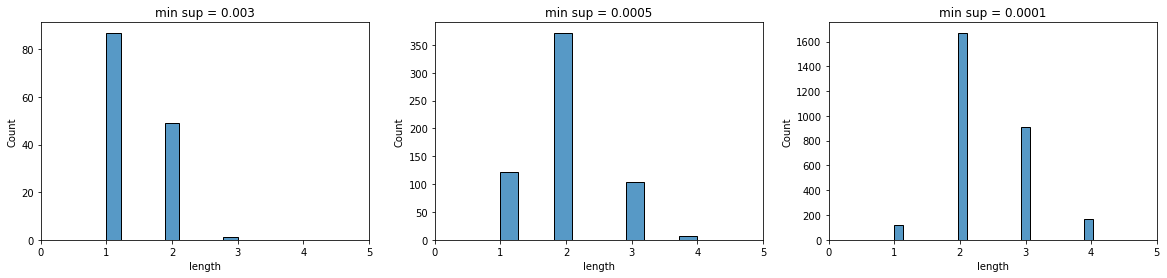

In [33]:
X_list = [0.003,0.0005,0.0001]
fig, axes = plt.subplots(1,3, figsize = (20,4))
for i in range(len(X_list)):
  Bfsets = fpgrowth(Btrans_df, min_support=X_list[i], use_colnames=True)
  Bfsets['length'] = Bfsets['itemsets'].apply(lambda x: len(x))
  sns.histplot(Bfsets.length, ax =axes[i]).set(xlim=(0,5))
  axes[i].set_title(f'min sup = {X_list[i]}');

**Let's take a look at the most bought items:**

In [34]:
print('Most frequent 1-itemsets:')
Bfsets.sort_values('support',ascending=False)[:10]

Most frequent 1-itemsets:


,support,itemsets,length
66,0.129602,(b_ sport.tennis),1
8,0.083848,(b_ computers.components.memory),1
122,0.076500,(b_ country_yard.lawn_mower),1
0,0.065977,(b_ appliances.kitchen.blender),1
60,0.061741,(b_ appliances.kitchen.toster),1
18,0.057407,(b_ computers.peripherals.monitor),1
14,0.055894,(b_ appliances.steam_cleaner),1
32,0.054075,(b_ medicine.tools.tonometer),1
71,0.050015,(b_ appliances.kitchen.grill),1
46,0.047336,(b_ appliances.environment.vacuum),1


The most frequent itemsets/bought items all have length one as expected. It's also possible to look at what are the most frequent 2-itemsets, in other words, what are the pairs of items that appear together most frequently.

In [35]:
print('Most frequent 2-itemsets:')
Bfsets[Bfsets.length == 2].sort_values('support',ascending = False)[:10]

Most frequent 2-itemsets:


,support,itemsets,length
2871,0.019146,"(b_ country_yard.lawn_mower, b_ sport.tennis)",2
462,0.014116,"(b_ computers.components.memory, b_ sport.tennis)",2
1897,0.012030,"(b_ appliances.kitchen.toster, b_ sport.tennis)",2
2110,0.011519,"(b_ appliances.kitchen.grill, b_ country_yard.lawn_mower)",2
320,0.011000,"(b_ computers.components.memory, b_ appliances.environment.fan)",2
1895,0.010859,"(b_ computers.components.memory, b_ appliances.kitchen.toster)",2
705,0.010256,"(b_ appliances.steam_cleaner, b_ country_yard.lawn_mower)",2
123,0.009716,"(b_ computers.components.memory, b_ appliances.kitchen.blender)",2
778,0.009220,"(b_ computers.peripherals.monitor, b_ sport.tennis)",2
780,0.008975,"(b_ computers.peripherals.monitor, b_ appliances.kitchen.toster)",2


Most of the items apearing here are in the most frequent 1-itemsets list. Finally let's look at the most frequent 3-itemsets

In [36]:
print('Most frequent 3-itemsets:')
Bfsets[Bfsets.length == 3].sort_values('support',ascending = False)[:10]

Most frequent 3-itemsets:


,support,itemsets,length
370,0.003112,"(b_ computers.components.memory, b_ appliances.environment.fan, b_ sport.tennis)",3
786,0.002855,"(b_ computers.peripherals.monitor, b_ appliances.kitchen.toster, b_ sport.tennis)",3
1899,0.002807,"(b_ computers.components.memory, b_ appliances.kitchen.toster, b_ sport.tennis)",3
1869,0.002594,"(b_ country_yard.lawn_mower, b_ appliances.kitchen.grill, b_ construction.tools.drill)",3
787,0.002223,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ appliances.kitchen.toster)",3
2113,0.002161,"(b_ appliances.kitchen.grill, b_ appliances.steam_cleaner, b_ country_yard.lawn_mower)",3
339,0.002047,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ appliances.environment.fan)",3
126,0.001815,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ sport.tennis)",3
1868,0.001768,"(b_ country_yard.lawn_mower, b_ appliances.steam_cleaner, b_ construction.tools.drill)",3
212,0.001762,"(b_ computers.components.memory, b_ electronics.clocks, b_ appliances.kitchen.toster)",3


Again, the most frequent items globally also makeup most of the top rules here. When calculating the association rules this has to be something taken into consideration. Also, to answer the question made at the top these are probably the most interesting items since they appear so often.

#### Clicked Itemsets

Since we only have 12 gb of RAM in our machine, we are limited in how low the support can go.

In [37]:
Cfsets = fpgrowth(Ctrans_df, min_support=0.0008, use_colnames=True)
Cfsets['length'] = Cfsets['itemsets'].apply(lambda x: len(x))
print('Most frequent itemsets:')
Cfsets.sort_values('support',ascending = False)[:10]

Most frequent itemsets:


,support,itemsets,length
87,0.149400,(c_ sport.tennis),1
11,0.097281,(c_ computers.components.memory),1
9,0.087810,(c_ computers.peripherals.monitor),1
46,0.083009,(c_ appliances.kitchen.toster),1
61,0.074043,(c_ medicine.tools.tonometer),1
78,0.069794,(c_ country_yard.lawn_mower),1
89,0.063547,(c_ appliances.steam_cleaner),1
15,0.063473,(c_ appliances.kitchen.blender),1
44,0.061022,(c_ appliances.kitchen.grill),1
26,0.060146,(c_ appliances.environment.vacuum),1



it seems like the most clicked items are, for the most part, also the most bought, which is to be expected

#### Clicked and bought Itemsets

In [38]:
BCfsets = fpgrowth(BCtrans_df, min_support=0.0008, use_colnames=True)
BCfsets['length'] = BCfsets['itemsets'].apply(lambda x: len(x))
print('Most frequent itemsets:')
BCfsets.sort_values('support',ascending = False)[:10]

Most frequent itemsets:


,support,itemsets,length
92,0.198051,(c_ sport.tennis),1
0,0.142063,(c_ computers.components.memory),1
20914,0.129602,"(c_ sport.tennis, b_ sport.tennis)",2
165,0.129602,(b_ sport.tennis),1
192,0.112268,(c_ country_yard.lawn_mower),1
63,0.103962,(c_ appliances.kitchen.toster),1
1,0.103522,(c_ appliances.kitchen.blender),1
51,0.101421,(c_ computers.peripherals.monitor),1
44,0.095172,(c_ medicine.tools.tonometer),1
21,0.083848,(b_ computers.components.memory),1


already it can be seen that the itemset clicks tennis, buys tennis is a very frequent itemset

### 1.3. Generate Association Rules from Frequent Itemsets

* Generate association rules with a choosed value (C) for minimum confidence. 
* Generate association rules with a choosed value (L) for minimum lift. 
* Generate association rules with both confidence >= C% and lift >= L.
* Change C and L when it makes sense and discuss the results.

#### 1.3.1 Bought Items

There are three variables that our rules depend on: minimum support, lift and confidence. Many experiments were made and bellow we show those that we think are more relevant.The lowest support is used and then some filtering is made when looking for rules with a different number of items. A more thorough analysis will be made for the bought items.

In [39]:
Bfsets = fpgrowth(Btrans_df, min_support=0.0001, use_colnames=True)

#### Testing confidence

With low minimum support and high confidence threshold, only rules with a high number of itemsets are returned. Also most of the rules have as one of the consequents itemsets that are very frequent. 

In [40]:
rules = association_rules(Bfsets, metric="confidence", min_threshold=0.7)[:50]
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(b_ furniture.living_room.shelving, b_ construction.tools.drill)",(b_ sport.tennis),0.000157,0.129602,0.000116,0.740000,5.709786,0.000096,3.347684
1,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
2,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116
3,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ computers.components.cpu)",(b_ appliances.environment.fan),0.000512,0.030448,0.000367,0.717791,23.574295,0.000352,3.435586
4,"(b_ computers.components.cpu, b_ appliances.kitchen.blender, b_ appliances.environment.fan)",(b_ computers.components.memory),0.000462,0.083848,0.000367,0.795918,9.492357,0.000329,4.489143
5,"(b_ computers.components.cpu, b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ computers.components.memory),0.000345,0.083848,0.000270,0.781818,9.324194,0.000241,4.199028
6,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis, b_ appliances.kitc...",(b_ computers.components.memory),0.000236,0.083848,0.000204,0.866667,10.336122,0.000184,6.871137
7,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ sport.tennis, b_ computers.co...",(b_ appliances.environment.fan),0.000270,0.030448,0.000204,0.755814,24.823063,0.000196,3.970546
8,"(b_ construction.tools.welding, b_ appliances.environment.fan, b_ computers.peripherals.joystick)",(b_ computers.components.memory),0.000154,0.083848,0.000110,0.714286,8.518782,0.000097,3.206531
9,"(b_ construction.tools.welding, b_ appliances.kitchen.mixer, b_ computers.peripherals.joystick)",(b_ computers.components.memory),0.000166,0.083848,0.000135,0.811321,9.676051,0.000121,4.855604



To get rules with less items, the threshold needs to be decreased, however this will yield many rules, so since we're not looking at lift yet, the support should be increased

In [41]:
rules = association_rules(Bfsets, metric="confidence", min_threshold=0.2)[:50]
rules[rules.support > 0.0005]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ computers.components.memory),0.005941,0.083848,0.001815,0.305497,3.643445,0.001317,1.319147
10,"(b_ computers.components.memory, b_ computers.peripherals.monitor)",(b_ electronics.clocks),0.005439,0.031428,0.001288,0.236721,7.532198,0.001117,1.268961
11,"(b_ computers.components.memory, b_ electronics.clocks)",(b_ computers.peripherals.monitor),0.004629,0.057407,0.001288,0.278155,4.845287,0.001022,1.305810
12,"(b_ computers.peripherals.monitor, b_ electronics.clocks)",(b_ computers.components.memory),0.005134,0.083848,0.001288,0.250765,2.990692,0.000857,1.222782
27,"(b_ computers.peripherals.monitor, b_ electronics.clocks)",(b_ sport.tennis),0.005134,0.129602,0.001159,0.225688,1.741393,0.000493,1.124092
28,"(b_ electronics.clocks, b_ sport.tennis)",(b_ computers.peripherals.monitor),0.004337,0.057407,0.001159,0.267198,4.654423,0.000910,1.286285
29,"(b_ computers.components.memory, b_ electronics.clocks)",(b_ sport.tennis),0.004629,0.129602,0.001149,0.248304,1.915895,0.000549,1.157912
30,"(b_ electronics.clocks, b_ sport.tennis)",(b_ computers.components.memory),0.004337,0.083848,0.001149,0.265025,3.160770,0.000786,1.246508
35,"(b_ computers.notebook, b_ electronics.clocks)",(b_ computers.peripherals.monitor),0.002801,0.057407,0.000600,0.214126,3.729938,0.000439,1.199419


already some interesting rules appear. Most of them actually involve the same items so that indicates a strong connection between them (for example memory, clocks and monitor)

#### Testing lift

Let's take a look at what happens when lift is used as threshold

In [42]:
rules = association_rules(Bfsets, metric="lift", min_threshold=3)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ computers.components.memory),0.005941,0.083848,0.001815,0.305497,3.643445,0.001317,1.319147
1,(b_ computers.components.memory),"(b_ appliances.kitchen.blender, b_ sport.tennis)",0.083848,0.005941,0.001815,0.021647,3.643445,0.001317,1.016053
2,"(b_ computers.components.memory, b_ electronics.video.tv)",(b_ accessories.bag),0.001467,0.025672,0.000135,0.092077,3.586715,0.000097,1.073140
3,(b_ accessories.bag),"(b_ computers.components.memory, b_ electronics.video.tv)",0.025672,0.001467,0.000135,0.005260,3.586715,0.000097,1.003813
4,"(b_ accessories.bag, b_ appliances.kitchen.blender)",(b_ computers.components.memory),0.001130,0.083848,0.000374,0.330556,3.942303,0.000279,1.368525
...,...,...,...,...,...,...,...,...,...
3751,"(b_ computers.peripherals.monitor, b_ sport.tennis)",(b_ sport.diving),0.009220,0.002085,0.000154,0.016689,8.003962,0.000135,1.014852
3752,"(b_ sport.diving, b_ sport.tennis)",(b_ computers.peripherals.monitor),0.000411,0.057407,0.000154,0.374046,6.515652,0.000130,1.505849
3753,(b_ computers.peripherals.monitor),"(b_ sport.diving, b_ sport.tennis)",0.057407,0.000411,0.000154,0.002680,6.515652,0.000130,1.002275
3754,(b_ sport.diving),"(b_ computers.peripherals.monitor, b_ sport.tennis)",0.002085,0.009220,0.000154,0.073795,8.003962,0.000135,1.069720


Values of lift higher than 1 indicate dependence, with very low support and no filtering for confidence we can see that the number of generated rules is too high to be manageable. Filtering should be performed on those variables, but once lift is the variable in study here, let's just increase the value of the threshold.

In [43]:
rules = association_rules(Bfsets, metric="lift", min_threshold=120)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(b_ computers.components.memory, b_ construction.tools.welding)","(b_ computers.peripherals.joystick, b_ appliances.kitchen.mixer)",0.002493,0.000446,0.000135,0.054156,121.448647,0.000134,1.056786
1,"(b_ computers.components.memory, b_ appliances.kitchen.mixer)","(b_ construction.tools.welding, b_ computers.peripherals.joystick)",0.001294,0.000751,0.000135,0.104369,139.061340,0.000134,1.115693
2,"(b_ construction.tools.welding, b_ computers.peripherals.joystick)","(b_ computers.components.memory, b_ appliances.kitchen.mixer)",0.000751,0.001294,0.000135,0.179916,139.061340,0.000134,1.217810
3,"(b_ computers.peripherals.joystick, b_ appliances.kitchen.mixer)","(b_ computers.components.memory, b_ construction.tools.welding)",0.000446,0.002493,0.000135,0.302817,121.448647,0.000134,1.430767
4,"(b_ appliances.kitchen.juicer, b_ appliances.steam_cleaner)","(b_ electronics.calculator, b_ construction.tools.drill)",0.000785,0.001193,0.000122,0.156000,130.729642,0.000122,1.183420
5,"(b_ electronics.calculator, b_ construction.tools.drill)","(b_ appliances.kitchen.juicer, b_ appliances.steam_cleaner)",0.001193,0.000785,0.000122,0.102632,130.729642,0.000122,1.113495
6,"(b_ computers.peripherals.printer, b_ computers.peripherals.camera)","(b_ furniture.bedroom.blanket, b_ computers.components.hdd)",0.001156,0.001664,0.000273,0.236413,142.045878,0.000271,1.307429
7,"(b_ furniture.bedroom.blanket, b_ computers.components.hdd)","(b_ computers.peripherals.printer, b_ computers.peripherals.camera)",0.001664,0.001156,0.000273,0.164151,142.045878,0.000271,1.195006
8,"(b_ computers.peripherals.printer, b_ furniture.bedroom.blanket)","(b_ appliances.environment.vacuum, b_ computers.peripherals.camera)",0.001272,0.000942,0.000148,0.116049,123.184099,0.000146,1.130219
9,"(b_ computers.peripherals.printer, b_ computers.peripherals.camera)","(b_ furniture.bedroom.blanket, b_ appliances.environment.vacuum)",0.001156,0.001052,0.000148,0.127717,121.405483,0.000146,1.145211


in order to get a manageable number of rules the threshold needs to be increased to 120! Note that all rules here have very low support and relatively low confidence. 

Until now, only experiences to get an idea of the number and the type of rules that appear were made. Now, we'll combine the filtering methods to make a full analysis.

#### Testing confidence and lift

We'll divide the analysis in 3 sections: low, medium and high support, since the values chosen for lift and confidence need to take the number of items into account.

* **For high support**:

The following piece of commented code illustrates how experiments were conducted. 9 combinations of sensible values of lift and confidence were tested:

* confidence: 0.1,0.4,0.7
* lift : 1.2, 3 , 5

It should be noted that even though 0.1 is a low value for confidence, if the support is high enough, rules can still be statistically significant.

Doing things this way makes it easier to identify what are the most relevant rules since you can easily go from most selective to less selectivefilters. So as to not cluter the notebook, the output will not be shown. 

In [95]:
rules = association_rules(Bfsets, metric="confidence", min_threshold=0.15)
confidence_list = [0.10,0.4,0.7]
lift_list = [1.2, 3 , 5 ]
min_support = 0.003
for conf in confidence_list:
    for lift in lift_list:
        print('Confidence:',conf,'   Lift:',lift)
        display(rules[(rules.confidence >= conf) 
                      & (rules.lift >= lift) & 
                      (rules.support >=min_support)].sort_values('confidence',ascending =False)[:20])

Confidence: 0.1    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
691,(b_ furniture.kitchen.table),(b_ computers.components.videocards),0.006193,0.022500,0.003282,0.529919,23.551917,0.003142,2.079428
257,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
205,(b_ appliances.environment.fan),(b_ computers.components.memory),0.030448,0.083848,0.011000,0.361283,4.308768,0.008447,1.434362
255,"(b_ computers.components.memory, b_ appliances.environment.fan)",(b_ sport.tennis),0.011000,0.129602,0.003112,0.282900,2.182838,0.001686,1.213775
1029,(b_ construction.tools.drill),(b_ appliances.steam_cleaner),0.033199,0.055894,0.008865,0.267026,4.777395,0.007009,1.288049
1594,(b_ country_yard.lawn_mower),(b_ sport.tennis),0.076500,0.129602,0.019146,0.250277,1.931120,0.009232,1.160959
1247,(b_ appliances.kitchen.grill),(b_ country_yard.lawn_mower),0.050015,0.076500,0.011519,0.230301,3.010463,0.007692,1.199819
256,"(b_ computers.components.memory, b_ sport.tennis)",(b_ appliances.environment.fan),0.014116,0.030448,0.003112,0.220467,7.240764,0.002682,1.243760
206,(b_ appliances.environment.fan),(b_ sport.tennis),0.030448,0.129602,0.006513,0.213903,1.650457,0.002567,1.107239
1128,(b_ appliances.kitchen.toster),(b_ sport.tennis),0.061741,0.129602,0.012030,0.194853,1.503470,0.004029,1.081042


Confidence: 0.1    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
691,(b_ furniture.kitchen.table),(b_ computers.components.videocards),0.006193,0.022500,0.003282,0.529919,23.551917,0.003142,2.079428
257,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
205,(b_ appliances.environment.fan),(b_ computers.components.memory),0.030448,0.083848,0.011000,0.361283,4.308768,0.008447,1.434362
1029,(b_ construction.tools.drill),(b_ appliances.steam_cleaner),0.033199,0.055894,0.008865,0.267026,4.777395,0.007009,1.288049
1247,(b_ appliances.kitchen.grill),(b_ country_yard.lawn_mower),0.050015,0.076500,0.011519,0.230301,3.010463,0.007692,1.199819
256,"(b_ computers.components.memory, b_ sport.tennis)",(b_ appliances.environment.fan),0.014116,0.030448,0.003112,0.220467,7.240764,0.002682,1.243760
1521,(b_ appliances.kitchen.microwave),(b_ electronics.clocks),0.017592,0.031428,0.003005,0.170832,5.435689,0.002452,1.168125
1028,(b_ appliances.steam_cleaner),(b_ construction.tools.drill),0.055894,0.033199,0.008865,0.158604,4.777395,0.007009,1.149045
1248,(b_ country_yard.lawn_mower),(b_ appliances.kitchen.grill),0.076500,0.050015,0.011519,0.150569,3.010463,0.007692,1.118377


Confidence: 0.1    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
691,(b_ furniture.kitchen.table),(b_ computers.components.videocards),0.006193,0.022500,0.003282,0.529919,23.551917,0.003142,2.079428
257,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
256,"(b_ computers.components.memory, b_ sport.tennis)",(b_ appliances.environment.fan),0.014116,0.030448,0.003112,0.220467,7.240764,0.002682,1.243760
1521,(b_ appliances.kitchen.microwave),(b_ electronics.clocks),0.017592,0.031428,0.003005,0.170832,5.435689,0.002452,1.168125


Confidence: 0.4    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
691,(b_ furniture.kitchen.table),(b_ computers.components.videocards),0.006193,0.022500,0.003282,0.529919,23.551917,0.003142,2.079428
257,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477


Confidence: 0.4    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
691,(b_ furniture.kitchen.table),(b_ computers.components.videocards),0.006193,0.022500,0.003282,0.529919,23.551917,0.003142,2.079428
257,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477


Confidence: 0.4    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
691,(b_ furniture.kitchen.table),(b_ computers.components.videocards),0.006193,0.022500,0.003282,0.529919,23.551917,0.003142,2.079428
257,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477


Confidence: 0.7    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Confidence: 0.7    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Confidence: 0.7    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


First, note that if the threshold are at a minimum then mostly rules with tennis and memory, the most frequent items of all, appear. Only when increasing the criteria, interesting behaviour starts to show. In general it's hard to make out what are the true rules regarding tennis for example because it has such high support. An analysis could be made to that item alone in order to figure out what is important. Since this is the most frequent item, that is an important analysis, but since it's out of the scope of the project we'll mostly disregard rules that involve this item.

Regarding the results perhaps the most interesting rule with a surprisingly high lift and confidence is the rule **kitchen table => videocards** as it is not at all obvious there is a connection between them.

Other rules that show up consistently with good values of confidence and lift are, by order of confidence:
* fan => memory
* microwave => clock
* grill => lawn_mower 
* drill => steam cleaner
* monitor => clock


The inverse rules also show up very often but the one with highest confidence was selected to be shown here.


* **For medium support (3-itemsets):** 

Now the results are also filtered by length

In [94]:
rules = association_rules(Bfsets, metric="confidence", min_threshold=0.1)
confidence_list = [0.1,0.4,0.7]
lift_list = [1.2, 3 , 5 ]
min_support = 0.002
for conf in confidence_list:
    for lift in lift_list:
        print('Confidence:',conf,'   Lift:',lift)
        display(rules[(rules.confidence >= conf) 
                      & (rules.lift >= lift) & 
                      (rules.support >=min_support)
                      & (rules.antecedents.apply(len)>1) ].sort_values('confidence',ascending =False)[:30])

Confidence: 0.1    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
327,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan)",(b_ computers.components.memory),0.003658,0.083848,0.002047,0.559657,6.674630,0.001741,2.080539
1642,"(b_ construction.tools.drill, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.004751,0.076500,0.002594,0.545935,7.136398,0.002230,2.033851
388,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
834,"(b_ computers.components.memory, b_ computers.peripherals.monitor)",(b_ appliances.kitchen.toster),0.005439,0.061741,0.002223,0.408776,6.620836,0.001888,1.586977
1641,"(b_ construction.tools.drill, b_ country_yard.lawn_mower)",(b_ appliances.kitchen.grill),0.006375,0.050015,0.002594,0.406897,8.135478,0.002275,1.601719
1815,"(b_ appliances.steam_cleaner, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.005430,0.076500,0.002161,0.397918,5.201534,0.001745,1.533844
831,"(b_ computers.peripherals.monitor, b_ appliances.kitchen.toster)",(b_ sport.tennis),0.008975,0.129602,0.002855,0.318055,2.454086,0.001691,1.276345
832,"(b_ computers.peripherals.monitor, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.009220,0.061741,0.002855,0.309605,5.014588,0.002285,1.359018
386,"(b_ computers.components.memory, b_ appliances.environment.fan)",(b_ sport.tennis),0.011000,0.129602,0.003112,0.282900,2.182838,0.001686,1.213775
1653,"(b_ computers.components.memory, b_ appliances.kitchen.toster)",(b_ sport.tennis),0.010859,0.129602,0.002807,0.258531,1.994806,0.001400,1.173883


Confidence: 0.1    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
327,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan)",(b_ computers.components.memory),0.003658,0.083848,0.002047,0.559657,6.674630,0.001741,2.080539
1642,"(b_ construction.tools.drill, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.004751,0.076500,0.002594,0.545935,7.136398,0.002230,2.033851
388,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
834,"(b_ computers.components.memory, b_ computers.peripherals.monitor)",(b_ appliances.kitchen.toster),0.005439,0.061741,0.002223,0.408776,6.620836,0.001888,1.586977
1641,"(b_ construction.tools.drill, b_ country_yard.lawn_mower)",(b_ appliances.kitchen.grill),0.006375,0.050015,0.002594,0.406897,8.135478,0.002275,1.601719
1815,"(b_ appliances.steam_cleaner, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.005430,0.076500,0.002161,0.397918,5.201534,0.001745,1.533844
832,"(b_ computers.peripherals.monitor, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.009220,0.061741,0.002855,0.309605,5.014588,0.002285,1.359018
833,"(b_ appliances.kitchen.toster, b_ sport.tennis)",(b_ computers.peripherals.monitor),0.012030,0.057407,0.002855,0.237275,4.133185,0.002164,1.235822
1640,"(b_ appliances.kitchen.grill, b_ country_yard.lawn_mower)",(b_ construction.tools.drill),0.011519,0.033199,0.002594,0.225191,6.783075,0.002211,1.247793
387,"(b_ computers.components.memory, b_ sport.tennis)",(b_ appliances.environment.fan),0.014116,0.030448,0.003112,0.220467,7.240764,0.002682,1.243760


Confidence: 0.1    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
327,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan)",(b_ computers.components.memory),0.003658,0.083848,0.002047,0.559657,6.674630,0.001741,2.080539
1642,"(b_ construction.tools.drill, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.004751,0.076500,0.002594,0.545935,7.136398,0.002230,2.033851
388,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
834,"(b_ computers.components.memory, b_ computers.peripherals.monitor)",(b_ appliances.kitchen.toster),0.005439,0.061741,0.002223,0.408776,6.620836,0.001888,1.586977
1641,"(b_ construction.tools.drill, b_ country_yard.lawn_mower)",(b_ appliances.kitchen.grill),0.006375,0.050015,0.002594,0.406897,8.135478,0.002275,1.601719
1815,"(b_ appliances.steam_cleaner, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.005430,0.076500,0.002161,0.397918,5.201534,0.001745,1.533844
832,"(b_ computers.peripherals.monitor, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.009220,0.061741,0.002855,0.309605,5.014588,0.002285,1.359018
1640,"(b_ appliances.kitchen.grill, b_ country_yard.lawn_mower)",(b_ construction.tools.drill),0.011519,0.033199,0.002594,0.225191,6.783075,0.002211,1.247793
387,"(b_ computers.components.memory, b_ sport.tennis)",(b_ appliances.environment.fan),0.014116,0.030448,0.003112,0.220467,7.240764,0.002682,1.243760
325,"(b_ computers.components.memory, b_ appliances.kitchen.blender)",(b_ appliances.environment.fan),0.009716,0.030448,0.002047,0.210730,6.920982,0.001752,1.228417


Confidence: 0.4    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
327,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan)",(b_ computers.components.memory),0.003658,0.083848,0.002047,0.559657,6.674630,0.001741,2.080539
1642,"(b_ construction.tools.drill, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.004751,0.076500,0.002594,0.545935,7.136398,0.002230,2.033851
388,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
834,"(b_ computers.components.memory, b_ computers.peripherals.monitor)",(b_ appliances.kitchen.toster),0.005439,0.061741,0.002223,0.408776,6.620836,0.001888,1.586977
1641,"(b_ construction.tools.drill, b_ country_yard.lawn_mower)",(b_ appliances.kitchen.grill),0.006375,0.050015,0.002594,0.406897,8.135478,0.002275,1.601719


Confidence: 0.4    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
327,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan)",(b_ computers.components.memory),0.003658,0.083848,0.002047,0.559657,6.674630,0.001741,2.080539
1642,"(b_ construction.tools.drill, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.004751,0.076500,0.002594,0.545935,7.136398,0.002230,2.033851
388,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
834,"(b_ computers.components.memory, b_ computers.peripherals.monitor)",(b_ appliances.kitchen.toster),0.005439,0.061741,0.002223,0.408776,6.620836,0.001888,1.586977
1641,"(b_ construction.tools.drill, b_ country_yard.lawn_mower)",(b_ appliances.kitchen.grill),0.006375,0.050015,0.002594,0.406897,8.135478,0.002275,1.601719


Confidence: 0.4    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
327,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan)",(b_ computers.components.memory),0.003658,0.083848,0.002047,0.559657,6.674630,0.001741,2.080539
1642,"(b_ construction.tools.drill, b_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.004751,0.076500,0.002594,0.545935,7.136398,0.002230,2.033851
388,"(b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.006513,0.083848,0.003112,0.477821,5.698630,0.002566,1.754477
834,"(b_ computers.components.memory, b_ computers.peripherals.monitor)",(b_ appliances.kitchen.toster),0.005439,0.061741,0.002223,0.408776,6.620836,0.001888,1.586977
1641,"(b_ construction.tools.drill, b_ country_yard.lawn_mower)",(b_ appliances.kitchen.grill),0.006375,0.050015,0.002594,0.406897,8.135478,0.002275,1.601719


Confidence: 0.7    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Confidence: 0.7    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Confidence: 0.7    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Curiously, the rules discovered for high support, show up combined with medium support. Among those the one that stands out is **grill, drill => lawn_mower** Besides those, there is a rule that considered interesting:
* fan, blender => memory
* camera, vacuum => blanket

Also, when removing the limit to 3-itemsets some other rules were found:
* blanket => camera
* camera => hdd
* cpu => fan

* **For low support (4-itemsets):** 

In [96]:
rules = association_rules(Bfsets, metric="confidence", min_threshold=0.15)
confidence_list = [0.1,0.4,0.7]
lift_list = [1.2, 3 , 5 ]
min_support = 0.0005
for conf in confidence_list:
    for lift in lift_list:
        print('Confidence:',conf,'   Lift:',lift)
        display(rules[(rules.confidence >= conf) 
                      & (rules.lift >= lift) & 
                      (rules.support >=min_support)
                      & (rules.antecedents.apply(len)>2)].sort_values('lift',ascending =False)[:30])

Confidence: 0.1    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
503,"(b_ computers.components.memory, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.cpu),0.003112,0.011054,0.000678,0.217962,19.718347,0.000644,1.264575
221,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ appliances.environment.fan),0.001815,0.030448,0.000763,0.420415,13.807622,0.000708,1.672839
118,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ appliances.kitchen.toster)",(b_ electronics.clocks),0.002223,0.031428,0.000788,0.354520,11.280445,0.000718,1.500545
116,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ electronics.clocks)",(b_ appliances.kitchen.toster),0.001288,0.061741,0.000788,0.612195,9.915562,0.000709,2.419410
102,"(b_ sport.tennis, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001171,0.057407,0.000590,0.504021,8.779750,0.000523,1.900471
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116
101,"(b_ computers.peripherals.monitor, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001159,0.061741,0.000590,0.509485,8.251995,0.000519,1.912805
223,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.001159,0.083848,0.000763,0.658537,7.853902,0.000666,2.683016
97,"(b_ computers.components.memory, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001149,0.061741,0.000556,0.483607,7.832847,0.000485,1.816946


Confidence: 0.1    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
503,"(b_ computers.components.memory, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.cpu),0.003112,0.011054,0.000678,0.217962,19.718347,0.000644,1.264575
221,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ appliances.environment.fan),0.001815,0.030448,0.000763,0.420415,13.807622,0.000708,1.672839
118,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ appliances.kitchen.toster)",(b_ electronics.clocks),0.002223,0.031428,0.000788,0.354520,11.280445,0.000718,1.500545
116,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ electronics.clocks)",(b_ appliances.kitchen.toster),0.001288,0.061741,0.000788,0.612195,9.915562,0.000709,2.419410
102,"(b_ sport.tennis, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001171,0.057407,0.000590,0.504021,8.779750,0.000523,1.900471
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116
101,"(b_ computers.peripherals.monitor, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001159,0.061741,0.000590,0.509485,8.251995,0.000519,1.912805
223,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.001159,0.083848,0.000763,0.658537,7.853902,0.000666,2.683016
97,"(b_ computers.components.memory, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001149,0.061741,0.000556,0.483607,7.832847,0.000485,1.816946


Confidence: 0.1    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
503,"(b_ computers.components.memory, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.cpu),0.003112,0.011054,0.000678,0.217962,19.718347,0.000644,1.264575
221,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ appliances.environment.fan),0.001815,0.030448,0.000763,0.420415,13.807622,0.000708,1.672839
118,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ appliances.kitchen.toster)",(b_ electronics.clocks),0.002223,0.031428,0.000788,0.354520,11.280445,0.000718,1.500545
116,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ electronics.clocks)",(b_ appliances.kitchen.toster),0.001288,0.061741,0.000788,0.612195,9.915562,0.000709,2.419410
102,"(b_ sport.tennis, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001171,0.057407,0.000590,0.504021,8.779750,0.000523,1.900471
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116
101,"(b_ computers.peripherals.monitor, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001159,0.061741,0.000590,0.509485,8.251995,0.000519,1.912805
223,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.001159,0.083848,0.000763,0.658537,7.853902,0.000666,2.683016
97,"(b_ computers.components.memory, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001149,0.061741,0.000556,0.483607,7.832847,0.000485,1.816946


Confidence: 0.4    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
221,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ appliances.environment.fan),0.001815,0.030448,0.000763,0.420415,13.807622,0.000708,1.672839
116,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ electronics.clocks)",(b_ appliances.kitchen.toster),0.001288,0.061741,0.000788,0.612195,9.915562,0.000709,2.419410
102,"(b_ sport.tennis, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001171,0.057407,0.000590,0.504021,8.779750,0.000523,1.900471
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116
101,"(b_ computers.peripherals.monitor, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001159,0.061741,0.000590,0.509485,8.251995,0.000519,1.912805
223,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.001159,0.083848,0.000763,0.658537,7.853902,0.000666,2.683016
97,"(b_ computers.components.memory, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001149,0.061741,0.000556,0.483607,7.832847,0.000485,1.816946
117,"(b_ computers.components.memory, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001762,0.057407,0.000788,0.447415,7.793705,0.000687,1.705789
562,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001743,0.061741,0.000816,0.468468,7.587659,0.000709,1.765199


Confidence: 0.4    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
221,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ appliances.environment.fan),0.001815,0.030448,0.000763,0.420415,13.807622,0.000708,1.672839
116,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ electronics.clocks)",(b_ appliances.kitchen.toster),0.001288,0.061741,0.000788,0.612195,9.915562,0.000709,2.419410
102,"(b_ sport.tennis, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001171,0.057407,0.000590,0.504021,8.779750,0.000523,1.900471
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116
101,"(b_ computers.peripherals.monitor, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001159,0.061741,0.000590,0.509485,8.251995,0.000519,1.912805
223,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.001159,0.083848,0.000763,0.658537,7.853902,0.000666,2.683016
97,"(b_ computers.components.memory, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001149,0.061741,0.000556,0.483607,7.832847,0.000485,1.816946
117,"(b_ computers.components.memory, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001762,0.057407,0.000788,0.447415,7.793705,0.000687,1.705789
562,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001743,0.061741,0.000816,0.468468,7.587659,0.000709,1.765199


Confidence: 0.4    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
221,"(b_ computers.components.memory, b_ appliances.kitchen.blender, b_ sport.tennis)",(b_ appliances.environment.fan),0.001815,0.030448,0.000763,0.420415,13.807622,0.000708,1.672839
116,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ electronics.clocks)",(b_ appliances.kitchen.toster),0.001288,0.061741,0.000788,0.612195,9.915562,0.000709,2.419410
102,"(b_ sport.tennis, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001171,0.057407,0.000590,0.504021,8.779750,0.000523,1.900471
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116
101,"(b_ computers.peripherals.monitor, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001159,0.061741,0.000590,0.509485,8.251995,0.000519,1.912805
223,"(b_ appliances.kitchen.blender, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.001159,0.083848,0.000763,0.658537,7.853902,0.000666,2.683016
97,"(b_ computers.components.memory, b_ electronics.clocks, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001149,0.061741,0.000556,0.483607,7.832847,0.000485,1.816946
117,"(b_ computers.components.memory, b_ electronics.clocks, b_ appliances.kitchen.toster)",(b_ computers.peripherals.monitor),0.001762,0.057407,0.000788,0.447415,7.793705,0.000687,1.705789
562,"(b_ computers.components.memory, b_ computers.peripherals.monitor, b_ sport.tennis)",(b_ appliances.kitchen.toster),0.001743,0.061741,0.000816,0.468468,7.587659,0.000709,1.765199


Confidence: 0.7    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116


Confidence: 0.7    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116


Confidence: 0.7    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(b_ computers.components.memory, b_ computers.components.cpu, b_ sport.tennis)",(b_ appliances.environment.fan),0.000864,0.030448,0.000678,0.785455,25.796544,0.000652,4.519098
506,"(b_ computers.components.cpu, b_ appliances.environment.fan, b_ sport.tennis)",(b_ computers.components.memory),0.000967,0.083848,0.000678,0.701299,8.363895,0.000597,3.067116


Most of the rules now appear to be versions of the rules we've already found but with more items. Doing a maximal set analysis will help in finding out what are the most relevant ones. Also note that the same items keep showing up. Removing them and repeating the analysis would probably be a good idea, but we feel it's out of the scope of this project. Also this means that digging for rules with more than 2 items as the antecedent is hard. Since we feel we've captured a good number of interactions than we'll stop our analysis of the bought items here.


#### 1.3.2 Clicked items

The same approach was used to discover the rules for the clicked itemsets. From now on, the code and steps will not go into so much detail, but that doesn't mean that a lot of experiences and fiddling with the support and confidence values wasn't made.

In [97]:
rules = association_rules(Cfsets, metric="confidence", min_threshold=0.15)
confidence_list = [0.2,0.4,0.7]
lift_list = [1.2, 3 , 5 ]
min_support = 0.0002
for conf in confidence_list:
    for lift in lift_list:
        print('Confidence:',conf,'   Lift:',lift)
        display(rules[(rules.confidence >= conf) 
                      & (rules.lift >= lift)  
                      & (rules.support >=min_support)
                        ][:20])

Confidence: 0.2    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"(c_ appliances.kitchen.blender, c_ appliances.personal.scales)",(c_ appliances.environment.vacuum),0.003988,0.060146,0.000994,0.249274,4.144489,0.000754,1.251927
4,"(c_ appliances.environment.vacuum, c_ appliances.personal.scales)",(c_ appliances.kitchen.blender),0.003504,0.063473,0.000994,0.283695,4.469523,0.000772,1.307442
9,(c_ computers.notebook),(c_ sport.tennis),0.056531,0.149400,0.011833,0.209316,1.401043,0.003387,1.075777
11,"(c_ computers.components.memory, c_ computers.notebook)",(c_ sport.tennis),0.006961,0.149400,0.002736,0.393008,2.630578,0.001696,1.401337
12,"(c_ computers.notebook, c_ sport.tennis)",(c_ computers.components.memory),0.011833,0.097281,0.002736,0.231182,2.376421,0.001584,1.174163
13,"(c_ computers.components.memory, c_ computers.notebook)",(c_ computers.peripherals.monitor),0.006961,0.087810,0.001551,0.222788,2.537158,0.000940,1.173669
15,"(c_ computers.notebook, c_ computers.peripherals.monitor)",(c_ computers.components.memory),0.007507,0.097281,0.001551,0.206568,2.123411,0.000820,1.137740
16,"(c_ computers.components.memory, c_ computers.notebook)",(c_ appliances.kitchen.toster),0.006961,0.083009,0.002012,0.289074,3.482452,0.001434,1.289855
18,"(c_ computers.notebook, c_ appliances.kitchen.toster)",(c_ computers.components.memory),0.009650,0.097281,0.002012,0.208510,2.143372,0.001073,1.140531
19,"(c_ computers.components.memory, c_ computers.notebook, c_ sport.tennis)",(c_ computers.peripherals.monitor),0.002736,0.087810,0.000813,0.297148,3.383980,0.000573,1.297840


Confidence: 0.2    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"(c_ appliances.kitchen.blender, c_ appliances.personal.scales)",(c_ appliances.environment.vacuum),0.003988,0.060146,0.000994,0.249274,4.144489,0.000754,1.251927
4,"(c_ appliances.environment.vacuum, c_ appliances.personal.scales)",(c_ appliances.kitchen.blender),0.003504,0.063473,0.000994,0.283695,4.469523,0.000772,1.307442
16,"(c_ computers.components.memory, c_ computers.notebook)",(c_ appliances.kitchen.toster),0.006961,0.083009,0.002012,0.289074,3.482452,0.001434,1.289855
19,"(c_ computers.components.memory, c_ computers.notebook, c_ sport.tennis)",(c_ computers.peripherals.monitor),0.002736,0.087810,0.000813,0.297148,3.383980,0.000573,1.297840
20,"(c_ computers.components.memory, c_ computers.notebook, c_ computers.peripherals.monitor)",(c_ sport.tennis),0.001551,0.149400,0.000813,0.524182,3.508581,0.000581,1.787657
21,"(c_ computers.components.memory, c_ sport.tennis, c_ computers.peripherals.monitor)",(c_ computers.notebook),0.003653,0.056531,0.000813,0.222542,3.936607,0.000606,1.213530
22,"(c_ computers.notebook, c_ sport.tennis, c_ computers.peripherals.monitor)",(c_ computers.components.memory),0.002372,0.097281,0.000813,0.342748,3.523261,0.000582,1.373473
23,"(c_ computers.components.memory, c_ computers.notebook, c_ sport.tennis)",(c_ appliances.kitchen.toster),0.002736,0.083009,0.000973,0.355626,4.284200,0.000746,1.423074
24,"(c_ computers.components.memory, c_ computers.notebook, c_ appliances.kitchen.toster)",(c_ sport.tennis),0.002012,0.149400,0.000973,0.483488,3.236203,0.000672,1.646817
25,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.kitchen.toster)",(c_ computers.notebook),0.004113,0.056531,0.000973,0.236550,4.184405,0.000740,1.235797


Confidence: 0.2    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
32,"(c_ appliances.kitchen.blender, c_ appliances.kitchen.toster)",(c_ computers.notebook),0.003702,0.056531,0.001093,0.295159,5.221156,0.000883,1.338556
75,"(c_ computers.notebook, c_ electronics.video.tv)",(c_ accessories.bag),0.004020,0.045220,0.001069,0.266031,5.883012,0.000888,1.300846
76,"(c_ computers.notebook, c_ accessories.bag)",(c_ electronics.video.tv),0.003776,0.033020,0.001069,0.283200,8.576668,0.000945,1.349024
78,"(c_ computers.components.memory, c_ electronics.video.tv)",(c_ appliances.iron),0.004033,0.043789,0.001037,0.257012,5.869331,0.000860,1.286980
80,"(c_ appliances.iron, c_ electronics.video.tv)",(c_ accessories.bag),0.003091,0.045220,0.000848,0.274205,6.063755,0.000708,1.315494
81,"(c_ appliances.iron, c_ accessories.bag)",(c_ electronics.video.tv),0.003743,0.033020,0.000848,0.226474,6.858730,0.000724,1.250094
85,"(c_ computers.components.memory, c_ electronics.video.tv)",(c_ accessories.bag),0.004033,0.045220,0.000978,0.242392,5.360252,0.000795,1.260256
107,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(c_ computers.components.memory),0.001797,0.097281,0.000894,0.497422,5.113230,0.000719,1.796177
113,"(c_ sport.tennis, c_ computers.components.cpu)",(c_ appliances.environment.fan),0.004418,0.032482,0.001520,0.344112,10.593782,0.001377,1.475125
116,"(c_ computers.components.memory, c_ computers.components.cpu)",(c_ appliances.environment.fan),0.003463,0.032482,0.001770,0.511110,15.734975,0.001658,1.979009


Confidence: 0.4    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
20,"(c_ computers.components.memory, c_ computers.notebook, c_ computers.peripherals.monitor)",(c_ sport.tennis),0.001551,0.149400,0.000813,0.524182,3.508581,0.000581,1.787657
24,"(c_ computers.components.memory, c_ computers.notebook, c_ appliances.kitchen.toster)",(c_ sport.tennis),0.002012,0.149400,0.000973,0.483488,3.236203,0.000672,1.646817
40,"(c_ computers.notebook, c_ appliances.kitchen.toster, c_ computers.peripherals.monitor)",(c_ sport.tennis),0.002201,0.149400,0.000883,0.401036,2.684311,0.000554,1.420118
107,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(c_ computers.components.memory),0.001797,0.097281,0.000894,0.497422,5.113230,0.000719,1.796177
108,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(c_ sport.tennis),0.001797,0.149400,0.000801,0.445866,2.984377,0.000533,1.535007
110,"(c_ computers.components.memory, c_ computers.components.cpu)",(c_ sport.tennis),0.003463,0.149400,0.001749,0.504886,3.379430,0.001231,1.717990
114,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ sport.tennis),0.002849,0.149400,0.001520,0.533604,3.571651,0.001095,1.823773
116,"(c_ computers.components.memory, c_ computers.components.cpu)",(c_ appliances.environment.fan),0.003463,0.032482,0.001770,0.511110,15.734975,0.001658,1.979009
117,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ computers.components.memory),0.002849,0.097281,0.001770,0.621257,6.386182,0.001493,2.383457
119,"(c_ computers.components.memory, c_ sport.tennis, c_ computers.components.cpu)",(c_ appliances.environment.fan),0.001749,0.032482,0.001089,0.622963,19.178455,0.001033,2.566104


Confidence: 0.4    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
20,"(c_ computers.components.memory, c_ computers.notebook, c_ computers.peripherals.monitor)",(c_ sport.tennis),0.001551,0.149400,0.000813,0.524182,3.508581,0.000581,1.787657
24,"(c_ computers.components.memory, c_ computers.notebook, c_ appliances.kitchen.toster)",(c_ sport.tennis),0.002012,0.149400,0.000973,0.483488,3.236203,0.000672,1.646817
107,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(c_ computers.components.memory),0.001797,0.097281,0.000894,0.497422,5.113230,0.000719,1.796177
110,"(c_ computers.components.memory, c_ computers.components.cpu)",(c_ sport.tennis),0.003463,0.149400,0.001749,0.504886,3.379430,0.001231,1.717990
114,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ sport.tennis),0.002849,0.149400,0.001520,0.533604,3.571651,0.001095,1.823773
116,"(c_ computers.components.memory, c_ computers.components.cpu)",(c_ appliances.environment.fan),0.003463,0.032482,0.001770,0.511110,15.734975,0.001658,1.979009
117,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ computers.components.memory),0.002849,0.097281,0.001770,0.621257,6.386182,0.001493,2.383457
119,"(c_ computers.components.memory, c_ sport.tennis, c_ computers.components.cpu)",(c_ appliances.environment.fan),0.001749,0.032482,0.001089,0.622963,19.178455,0.001033,2.566104
120,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ sport.tennis),0.001770,0.149400,0.001089,0.615377,4.118992,0.000825,2.211516
121,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ computers.components.memory),0.001520,0.097281,0.001089,0.716462,7.364837,0.000941,3.183762


Confidence: 0.4    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
107,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(c_ computers.components.memory),0.001797,0.097281,0.000894,0.497422,5.113230,0.000719,1.796177
116,"(c_ computers.components.memory, c_ computers.components.cpu)",(c_ appliances.environment.fan),0.003463,0.032482,0.001770,0.511110,15.734975,0.001658,1.979009
117,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ computers.components.memory),0.002849,0.097281,0.001770,0.621257,6.386182,0.001493,2.383457
119,"(c_ computers.components.memory, c_ sport.tennis, c_ computers.components.cpu)",(c_ appliances.environment.fan),0.001749,0.032482,0.001089,0.622963,19.178455,0.001033,2.566104
121,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ computers.components.memory),0.001520,0.097281,0.001089,0.716462,7.364837,0.000941,3.183762
179,"(c_ computers.components.memory, c_ electronics.clocks, c_ appliances.kitchen.toster)",(c_ computers.peripherals.monitor),0.001855,0.087810,0.000874,0.471232,5.366493,0.000711,1.725124
180,"(c_ computers.components.memory, c_ electronics.clocks, c_ computers.peripherals.monitor)",(c_ appliances.kitchen.toster),0.001968,0.083009,0.000874,0.444183,5.351032,0.000711,1.649807
184,"(c_ electronics.clocks, c_ sport.tennis, c_ appliances.kitchen.toster)",(c_ computers.peripherals.monitor),0.001730,0.087810,0.000877,0.506949,5.773247,0.000725,1.850094
192,"(c_ electronics.clocks, c_ sport.tennis, c_ appliances.kitchen.toster)",(c_ computers.components.memory),0.001730,0.097281,0.000847,0.489756,5.034426,0.000679,1.769190
354,"(c_ appliances.iron, c_ country_yard.lawn_mower, c_ sport.tennis)",(c_ appliances.kitchen.toster),0.001818,0.083009,0.000816,0.448888,5.407709,0.000665,1.663891


Confidence: 0.7    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
121,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ computers.components.memory),0.00152,0.097281,0.001089,0.716462,7.364837,0.000941,3.183762


Confidence: 0.7    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
121,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ computers.components.memory),0.00152,0.097281,0.001089,0.716462,7.364837,0.000941,3.183762


Confidence: 0.7    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
121,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(c_ computers.components.memory),0.00152,0.097281,0.001089,0.716462,7.364837,0.000941,3.183762


After fiddling with the parameters we found that patterns familiar to the ones found in the bought items also show up here, like the rule drill, grill => fan or blanket => camera or fan => memory, which validates those rules, but there are also some new patterns, namely:

* cooler => scales
* blanket => hdd 
* tv, memory => iron
* tv, notebook => bag
* hdd, vacuum => printer
* toster , blender => notebook

all of these rules have a lift greater than 5 a confidence greater than 0.25 in most cases and a support that corresponds at least to thousands of occurences. There are more interesting rules, but we feel like the goal here is not quantity, but quality.

Most of these rules reveal something interesting. One would not expect  a relationship between a blanket and a hdd to exist for example.

Also, from what we've seen so far there seem to be some groups of items that generally appear together like drill, grill and lawn_mower, or fan and memory, or blanket,camera and hdd


#### 1.3.3 Clicked and bought items

In this section generating the rules is not enough. It's also necessary to filter the rules that have clicked items as antecedents and bought items as consequents. In the next cell, functions that are used to filter these results are defined

In [48]:
def c_antecedents(itemset):
    c = True
    for item in itemset:
    if item.startswith('b_'):
        c = False
    return c

def b_consequents(itemset):
    b = True
    for item in itemset:
    if item.startswith('c_'):
        b = False
    return b

In [49]:
rules = association_rules(BCfsets, metric="confidence", min_threshold=0.1)
#filtering
rules= rules[rules.antecedents.apply(c_antecedents) & rules.consequents.apply(b_consequents)]
confidence_list = [0.1,0.4,0.7]
lift_list = [1.2, 3 , 5 ]
min_support = 0.002
for conf in confidence_list:
    for lift in lift_list:
        print('Confidence:',conf,'   Lift:',lift)
        display(rules[(rules.confidence >= conf) 
                      & (rules.lift >= lift)  
                      & (rules.support >=min_support)
                       ].sort_values('confidence',ascending=False)[:20])

Confidence: 0.1    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


Confidence: 0.1    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


Confidence: 0.1    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


Confidence: 0.4    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


Confidence: 0.4    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


Confidence: 0.4    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


Confidence: 0.7    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


Confidence: 0.7    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


Confidence: 0.7    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36583,(c_ computers.gaming),(b_ computers.gaming),0.047572,0.041075,0.041075,0.863423,21.020793,0.039121,7.021150
76105,"(c_ computers.components.videocards, c_ furniture.kitchen.table)",(b_ computers.components.videocards),0.005794,0.022500,0.004987,0.860705,38.253485,0.004856,7.017461
55275,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.005367,0.030448,0.004582,0.853716,28.038430,0.004418,6.627857
55312,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ appliances.environment.fan),0.003737,0.030448,0.003187,0.852941,28.012995,0.003074,6.592953
55287,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004538,0.030448,0.003756,0.827682,27.183401,0.003618,5.626516
55259,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.006912,0.030448,0.005583,0.807815,26.530912,0.005373,5.044879
52340,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.002572,0.030448,0.002066,0.803419,26.386541,0.001988,4.932069
53853,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.005367,0.083848,0.004045,0.753657,8.988337,0.003595,3.719010
53942,"(c_ computers.components.memory, c_ sport.tennis, c_ appliances.environment.fan, c_ computers.co...",(b_ computers.components.memory),0.003737,0.083848,0.002792,0.747059,8.909644,0.002478,3.621995
100037,"(c_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.007738,0.076500,0.005621,0.726461,9.496209,0.005029,3.376118


There are many rules with a suspiciously high confidence. Indeed the algorithm is finding many rules that have the same item in the consequents and antecedents, which is natural since to buy something you need to click on it. The next step will be to filter these rules, but we can learn something from them too. For example, it might be usefull to know that when buying a fan, very often people also click on memory and cpu.

In [50]:
#filtering function
def filter_repeated_item(antecedents, consequents):
    return_value = True
    for ant in antecedents:
        if ant.replace('c_','b_') in consequents:
            return False   
    return True

In [51]:
rules = association_rules(BCfsets, metric="confidence", min_threshold=0.1)
#filtering
rules= rules[rules.antecedents.apply(c_antecedents) & rules.consequents.apply(b_consequents)]
rules = rules[rules.apply(lambda x: filter_repeated_item(x.antecedents, x.consequents), axis=1)]
confidence_list = [0.1,0.4,0.7]
lift_list = [1.2, 3 , 5 ]
min_support = 0.002
for conf in confidence_list:
    for lift in lift_list:
        print('Confidence:',conf,'   Lift:',lift)
        display(rules[(rules.confidence >= conf) 
                      & (rules.lift >= lift)  
                      & (rules.support >=min_support)
                      & (rules.antecedents.apply(len) == 2) ].sort_values('confidence',ascending=False)[:20])

Confidence: 0.1    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
55265,"(c_ computers.components.memory, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.007706,0.030448,0.004582,0.594540,19.526356,0.004347,2.391237
53839,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.006912,0.083848,0.004045,0.585189,6.979131,0.003465,2.208598
100024,"(c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.012288,0.076500,0.005621,0.457450,5.979724,0.004681,1.702146
55270,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.008378,0.030448,0.003756,0.448276,14.722644,0.003501,1.757313
52161,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ computers.components.memory),0.004858,0.083848,0.002142,0.440853,5.257746,0.001734,1.638482
24492,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan)",(b_ computers.components.memory),0.010162,0.083848,0.004409,0.433869,5.174449,0.003557,1.618268
52167,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004858,0.030448,0.002066,0.425339,13.969345,0.001918,1.687173
53848,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ computers.components.memory),0.008378,0.083848,0.003420,0.408171,4.867967,0.002717,1.548000
24474,"(c_ sport.tennis, c_ appliances.environment.fan)",(b_ computers.components.memory),0.018672,0.083848,0.006978,0.373697,4.456816,0.005412,1.462792
75824,"(c_ computers.components.hdd, c_ furniture.bedroom.blanket)",(b_ computers.peripherals.camera),0.005514,0.010677,0.002054,0.372437,34.882483,0.001995,1.576453


Confidence: 0.1    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
55265,"(c_ computers.components.memory, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.007706,0.030448,0.004582,0.594540,19.526356,0.004347,2.391237
53839,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.006912,0.083848,0.004045,0.585189,6.979131,0.003465,2.208598
100024,"(c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.012288,0.076500,0.005621,0.457450,5.979724,0.004681,1.702146
55270,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.008378,0.030448,0.003756,0.448276,14.722644,0.003501,1.757313
52161,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ computers.components.memory),0.004858,0.083848,0.002142,0.440853,5.257746,0.001734,1.638482
24492,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan)",(b_ computers.components.memory),0.010162,0.083848,0.004409,0.433869,5.174449,0.003557,1.618268
52167,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004858,0.030448,0.002066,0.425339,13.969345,0.001918,1.687173
53848,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ computers.components.memory),0.008378,0.083848,0.003420,0.408171,4.867967,0.002717,1.548000
24474,"(c_ sport.tennis, c_ appliances.environment.fan)",(b_ computers.components.memory),0.018672,0.083848,0.006978,0.373697,4.456816,0.005412,1.462792
75824,"(c_ computers.components.hdd, c_ furniture.bedroom.blanket)",(b_ computers.peripherals.camera),0.005514,0.010677,0.002054,0.372437,34.882483,0.001995,1.576453


Confidence: 0.1    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
55265,"(c_ computers.components.memory, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.007706,0.030448,0.004582,0.594540,19.526356,0.004347,2.391237
53839,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.006912,0.083848,0.004045,0.585189,6.979131,0.003465,2.208598
100024,"(c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.012288,0.076500,0.005621,0.457450,5.979724,0.004681,1.702146
55270,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.008378,0.030448,0.003756,0.448276,14.722644,0.003501,1.757313
52161,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ computers.components.memory),0.004858,0.083848,0.002142,0.440853,5.257746,0.001734,1.638482
24492,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan)",(b_ computers.components.memory),0.010162,0.083848,0.004409,0.433869,5.174449,0.003557,1.618268
52167,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004858,0.030448,0.002066,0.425339,13.969345,0.001918,1.687173
75824,"(c_ computers.components.hdd, c_ furniture.bedroom.blanket)",(b_ computers.peripherals.camera),0.005514,0.010677,0.002054,0.372437,34.882483,0.001995,1.576453
85449,"(c_ computers.components.power_supply, c_ appliances.kitchen.grill)",(b_ medicine.tools.tonometer),0.007935,0.054075,0.002660,0.335180,6.198378,0.002231,1.422828
72039,"(c_ kids.bottles, c_ construction.tools.drill)",(b_ appliances.steam_cleaner),0.006243,0.055894,0.002047,0.327968,5.867711,0.001699,1.404853


Confidence: 0.4    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
55265,"(c_ computers.components.memory, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.007706,0.030448,0.004582,0.594540,19.526356,0.004347,2.391237
53839,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.006912,0.083848,0.004045,0.585189,6.979131,0.003465,2.208598
100024,"(c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.012288,0.076500,0.005621,0.457450,5.979724,0.004681,1.702146
55270,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.008378,0.030448,0.003756,0.448276,14.722644,0.003501,1.757313
52161,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ computers.components.memory),0.004858,0.083848,0.002142,0.440853,5.257746,0.001734,1.638482
24492,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan)",(b_ computers.components.memory),0.010162,0.083848,0.004409,0.433869,5.174449,0.003557,1.618268
52167,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004858,0.030448,0.002066,0.425339,13.969345,0.001918,1.687173
53848,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ computers.components.memory),0.008378,0.083848,0.003420,0.408171,4.867967,0.002717,1.548000


Confidence: 0.4    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
55265,"(c_ computers.components.memory, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.007706,0.030448,0.004582,0.594540,19.526356,0.004347,2.391237
53839,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.006912,0.083848,0.004045,0.585189,6.979131,0.003465,2.208598
100024,"(c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.012288,0.076500,0.005621,0.457450,5.979724,0.004681,1.702146
55270,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.008378,0.030448,0.003756,0.448276,14.722644,0.003501,1.757313
52161,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ computers.components.memory),0.004858,0.083848,0.002142,0.440853,5.257746,0.001734,1.638482
24492,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan)",(b_ computers.components.memory),0.010162,0.083848,0.004409,0.433869,5.174449,0.003557,1.618268
52167,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004858,0.030448,0.002066,0.425339,13.969345,0.001918,1.687173
53848,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ computers.components.memory),0.008378,0.083848,0.003420,0.408171,4.867967,0.002717,1.548000


Confidence: 0.4    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
55265,"(c_ computers.components.memory, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.007706,0.030448,0.004582,0.594540,19.526356,0.004347,2.391237
53839,"(c_ appliances.environment.fan, c_ computers.components.cpu)",(b_ computers.components.memory),0.006912,0.083848,0.004045,0.585189,6.979131,0.003465,2.208598
100024,"(c_ appliances.kitchen.grill, c_ construction.tools.drill)",(b_ country_yard.lawn_mower),0.012288,0.076500,0.005621,0.457450,5.979724,0.004681,1.702146
55270,"(c_ sport.tennis, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.008378,0.030448,0.003756,0.448276,14.722644,0.003501,1.757313
52161,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ computers.components.memory),0.004858,0.083848,0.002142,0.440853,5.257746,0.001734,1.638482
24492,"(c_ appliances.kitchen.blender, c_ appliances.environment.fan)",(b_ computers.components.memory),0.010162,0.083848,0.004409,0.433869,5.174449,0.003557,1.618268
52167,"(c_ appliances.kitchen.blender, c_ computers.components.cpu)",(b_ appliances.environment.fan),0.004858,0.030448,0.002066,0.425339,13.969345,0.001918,1.687173


Confidence: 0.7    Lift: 1.2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Confidence: 0.7    Lift: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Confidence: 0.7    Lift: 5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


On a first look, first there is the confirmation of the group of items we named earlier as there is the following rule:
* grill, steam_cleaner, drill => lawn_mower
with good metrics.

Also the rule:
* table => videocards
shows up again but now the interpretation is slightly diferent of course.

There are also a bunch of rules that we list because they might be interesting.

Next, we make an exception and include a rule with tennis because its metrics (sup = 0.003, conf = 0.64 and lift=24) are too good to be ignored:
* tennis, memory, cpu => fan

Besides this, there are a bunch of rules that might be interesting:
* juicer => drill
* cpu => fan
* blanket => camera
* blanket => printer
* tonometer, power supply => grill


### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets

#### 1.4.1 Bought items

Maximal frequent itemset analysis is usefull mostly to single out long itemsets that might be relevant. Out of curiosity, let's first take a look at short maximal itemsets:

In [62]:
Bmaxsets = fpmax(Btrans_df, min_support=0.0001, use_colnames=True)

In [73]:
Bmaxsets[(Bmaxsets.support>0.0001) & (Bmaxsets.itemsets.apply(len) == 1)].sort_values('support',ascending=False)

,support,itemsets
17,0.001504,(b_ accessories.umbrella)
16,0.001375,(b_ electronics.audio.dictaphone)
14,0.001322,(b_ furniture.bathroom.bath)
7,0.001083,(b_ construction.components.faucet)
6,0.001024,(b_ electronics.audio.acoustic)
5,0.000653,(b_ appliances.environment.air_heater)
1,0.000333,(b_ kids.carriage)
0,0.000279,(b_ auto.accessories.alarm)


there are few maximal itemsets with just one item. This are all very specific (things you buy rarely or that you need to consider before you buy one), so possibly people went to the store to buy this item only. An interesting exception is umbrella. Most likely, in occasions where it started to rain people went to the store specifically to buy it, that's why it is maximal. Now for the maximal itemsets with 3 items:

In [77]:
Bmaxsets[(Bmaxsets.support>0.0003) & (Bmaxsets.itemsets.apply(len) == 3)].sort_values('support',ascending = False)

,support,itemsets
670,0.000427,"(b_ apparel.trousers, b_ country_yard.lawn_mower, b_ sport.tennis)"
1706,0.000402,"(b_ country_yard.lawn_mower, b_ sport.tennis, b_ appliances.iron)"
1445,0.000396,"(b_ computers.components.memory, b_ appliances.kitchen.toster, b_ appliances.kitchen.microwave)"
1927,0.000396,"(b_ medicine.tools.tonometer, b_ computers.peripherals.monitor, b_ computers.notebook)"
1922,0.000386,"(b_ computers.notebook, b_ appliances.kitchen.grill, b_ country_yard.lawn_mower)"
1832,0.000380,"(b_ electronics.clocks, b_ country_yard.lawn_mower, b_ sport.tennis)"
1733,0.000374,"(b_ computers.components.memory, b_ accessories.bag, b_ appliances.kitchen.blender)"
2032,0.000358,"(b_ appliances.steam_cleaner, b_ appliances.kitchen.toster, b_ sport.tennis)"
1441,0.000352,"(b_ computers.notebook, b_ appliances.kitchen.toster, b_ appliances.kitchen.microwave)"
1757,0.000349,"(b_ computers.notebook, b_ appliances.steam_cleaner, b_ electronics.video.tv)"


There are many itemsets here that haven't shown up on our analysis. It would be good to calculate association rules with these and try to see if there is usefull information. Now with four items:

In [82]:
Bmaxsets[(Bmaxsets.support>0.0002) & (Bmaxsets.itemsets.apply(len) == 4)].sort_values('support',ascending = False)

,support,itemsets
1890,0.000458,"(b_ country_yard.lawn_mower, b_ appliances.kitchen.grill, b_ appliances.steam_cleaner, b_ construction.tools.drill)"
1889,0.000339,"(b_ country_yard.lawn_mower, b_ appliances.kitchen.grill, b_ construction.tools.drill, b_ sport.tennis)"
2041,0.000333,"(b_ computers.components.memory, b_ country_yard.lawn_mower, b_ appliances.kitchen.toster, b_ sport.tennis)"
1800,0.000327,"(b_ computers.components.memory, b_ appliances.environment.fan, b_ appliances.kitchen.toster, b_ sport.tennis)"
1988,0.000273,"(b_ appliances.kitchen.grill, b_ appliances.environment.vacuum, b_ country_yard.lawn_mower, b_ appliances.kitchen.toster)"
847,0.000273,"(b_ computers.peripherals.printer, b_ computers.peripherals.camera, b_ computers.components.hdd, b_ furniture.bedroom.blanket)"
1574,0.000270,"(b_ country_yard.lawn_mower, b_ appliances.kitchen.grill, b_ appliances.steam_cleaner, b_ kids.bottles)"
1855,0.000261,"(b_ country_yard.lawn_mower, b_ construction.tools.drill, b_ appliances.kitchen.grill, b_ appliances.kitchen.blender)"
2010,0.000248,"(b_ medicine.tools.tonometer, b_ appliances.kitchen.grill, b_ appliances.steam_cleaner, b_ country_yard.lawn_mower)"
1984,0.000242,"(b_ computers.components.memory, b_ appliances.kitchen.grill, b_ appliances.environment.vacuum, b_ appliances.kitchen.toster)"


There it is again, the group lawn_mower, grill, steam_cleaner and drill. Also, tonometer appears quite often with some of the items in these groups, perhaps a closer investigation would be due. Also, this results here could serve as basis to analyse the association rules with 4-items calculated previously. Let's move on to the clicked items

#### Clicked items

In [84]:
Cmaxsets = fpmax(Ctrans_df, min_support=0.007, use_colnames=True)

In [91]:
Cmaxsets[(Cmaxsets.support>0.02) & (Cmaxsets.itemsets.apply(len) == 1)].sort_values('support', ascending = False)

,support,itemsets
86,0.060146,(c_ appliances.environment.vacuum)
78,0.045220,(c_ accessories.bag)
74,0.037975,(c_ electronics.telephone)
73,0.037596,(c_ computers.components.hdd)
72,0.033877,(c_ appliances.kitchen.mixer)
71,0.033020,(c_ electronics.video.tv)
68,0.032058,(c_ computers.peripherals.printer)
66,0.029330,(c_ stationery.cartrige)
65,0.028286,(c_ kids.bottles)
64,0.027177,(c_ computers.peripherals.scanner)


Perhaps it is surprising that hdd shows up as a maximal set here since it shows up in a considerable number of association rules. Also it's notable that the maximal sets from the clicked items are different than the bought items and present a much higher support. It is properly not worth it to look at the maximal sets from the clicked and boughts itemsets because most likely we're going to run into the same problem as before of only clicked or only bought items showing up.

### 1.5. Conclusions 

Most of the questions posed at the beggining of the notebook regarding this part have been answered in the analysis.

The first conclusion is that the support is very important for severall reasons. First of all, depending on the size of the dataset the minimum support needs to be adjusted. Also, depending on the support itemsets with different length sizes will be selected because longer itemsets are naturally less likely to occur and that has to be taken into consideration in the analysis.

Overall, exploring the association rules from the outset was hard because they are dependent on three variables: the support, lift and confidence (possibly more metrics). Even so, relevant association rules between clicked, bought and clicked and bought items were found. 


It is hard to limit how deep this analysis could go. In a real life example, a possibility of things should be tried to improve results:
* talk with experts that know the dynamics of the supermarket
* include the maximal itemset analysis in the association rules
* repeat the association rules with the most frequent items like tennis and memory removed.



# 2. Week vs Weekend Purchases

In this part of the project you should analyse the consumption patterns during the week vs during the weekeed.

**In what follows keep the following question in mind and be creative!**

1. The most interesting products are the same during the week and the weekend? 
2. What are the most bought products during the week? And during the weekend?
3. There are differences between the sets of products bought during the week and the weekend?
4. Can you find different associations highliting that when people click in a product/set of products also buy this product(s) during the week vs the weekend?
5. Discuss the results obtained for the week sessions vs weekend sessions.

### 2.1. Load and Preprocess Data

 **Product quantities should not be considered.**

The loading of all datsets was already performed, so we will just make a preprocessing similar to the first part, but dividing the purchases by week days and weekend days.

### Preprocess data

Bought items

In [ ]:
#Getting an integer based on the day of the week, where 0 is Monday and 6 is sunday
Bdata["day"] = Bdata["timestamp"].dt.weekday.astype("int")

#Splitting the week and weekend days
Bdata_week = Bdata[Bdata["day"] < 5]
Bdata_weekend = Bdata[Bdata["day"] >= 5]

#Preprocessing the new dataframes to transform them into itemsets
Bitems_week = Bdata_week[['item_id','session_id']]
Bitems_week["category"] = Bitems_week["item_id"].apply(lambda x: Pdata.b_category.loc[x])
Bitems_week.drop('item_id',axis=1, inplace=True)
Bitems_week = Bitems_week.groupby('session_id')['category'].apply(list).reset_index(name='item_names')

Bitems_weekend = Bdata_weekend[['item_id','session_id']]
Bitems_weekend["category"] = Bitems_weekend["item_id"].apply(lambda x: Pdata.b_category.loc[x])
Bitems_weekend.drop('item_id',axis=1, inplace=True)
Bitems_weekend = Bitems_weekend.groupby('session_id')['category'].apply(list).reset_index(name='item_names')

Clicked items

In [ ]:
#Getting an integer based on the day of the week, where 0 is Monday and 6 is sunday
Cdata["day"] = Cdata["timestamp"].dt.weekday.astype("int")

#Splitting the week and weekend days
Cdata_week = Cdata[Cdata["day"] < 5]
Cdata_weekend = Cdata[Cdata["day"] >= 5]

#Preprocessing the new dataframes to transform them into itemsets
Citems_week = Cdata_week[['item_id','session_id']]
Citems_week["category"] = Citems_week["item_id"].apply(lambda x: Pdata.c_category.loc[x])
Citems_week.drop('item_id',axis=1, inplace=True)
Citems_week = Citems_week.groupby('session_id')['category'].apply(list).reset_index(name='item_names')

Citems_weekend = Cdata_weekend[['item_id','session_id']]
Citems_weekend["category"] = Citems_weekend["item_id"].apply(lambda x: Pdata.c_category.loc[x])
Citems_weekend.drop('item_id',axis=1, inplace=True)
Citems_weekend = Citems_weekend.groupby('session_id')['category'].apply(list).reset_index(name='item_names')

Clicked and bought items

In [ ]:
CBitems_week = pd.merge(Citems_week,Bitems_week, on='session_id')
CBitems_week['item_names'] = CBitems_week['item_names_x'] + CBitems_week['item_names_y']
CBitems_week.drop(['item_names_x','item_names_y'], inplace=True,axis=1)

CBitems_weekend = pd.merge(Citems_weekend,Bitems_weekend, on='session_id')
CBitems_weekend['item_names'] = CBitems_weekend['item_names_x'] + CBitems_weekend['item_names_y']
CBitems_weekend.drop(['item_names_x','item_names_y'], inplace=True,axis=1)


### Encode Data

Bought items

In [ ]:
Bitems_week_list = Bitems_week.item_names.to_list()
B_week_trans = encoder.fit(Bitems_week_list).transform(Bitems_week_list, sparse=True)
B_week_df = pd.DataFrame.sparse.from_spmatrix(B_week_trans, columns=encoder.columns_)

Bitems_weekend_list = Bitems_weekend.item_names.to_list()
B_weekend_trans = encoder.fit(Bitems_weekend_list).transform(Bitems_weekend_list, sparse=True)
B_weekend_df = pd.DataFrame.sparse.from_spmatrix(B_weekend_trans, columns=encoder.columns_)

Clicked items

In [ ]:
Citems_week_list = Citems_week.item_names.to_list()
C_week_trans = encoder.fit(Citems_week_list).transform(Citems_week_list, sparse=True)
C_week_df = pd.DataFrame.sparse.from_spmatrix(C_week_trans, columns=encoder.columns_)

Citems_weekend_list = Citems_weekend.item_names.to_list()
C_weekend_trans = encoder.fit(Citems_weekend_list).transform(Citems_weekend_list, sparse=True)
C_weekend_df = pd.DataFrame.sparse.from_spmatrix(C_weekend_trans, columns=encoder.columns_)

Clicked and Bought items

In [ ]:
CBitems_week_list = CBitems_week.item_names.to_list()
CB_week_trans = encoder.fit(CBitems_week_list).transform(CBitems_week_list, sparse=True)
CB_week_df = pd.DataFrame.sparse.from_spmatrix(CB_week_trans, columns=encoder.columns_)

CBitems_weekend_list = CBitems_weekend.item_names.to_list()
CB_weekend_trans = encoder.fit(CBitems_weekend_list).transform(CBitems_weekend_list, sparse=True)
CB_weekend_df = pd.DataFrame.sparse.from_spmatrix(CB_weekend_trans, columns=encoder.columns_)

### 2.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support of X%. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.
* Change X and Y when it makes sense and discuss the results.

Like it was done on the first part, let's plot the distributions of the frequent itemsets for different values of support (X%), as it can take several different values and we are not sure which ones are more suitable for this itemsets.

#### 2.2.1 Bought items

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

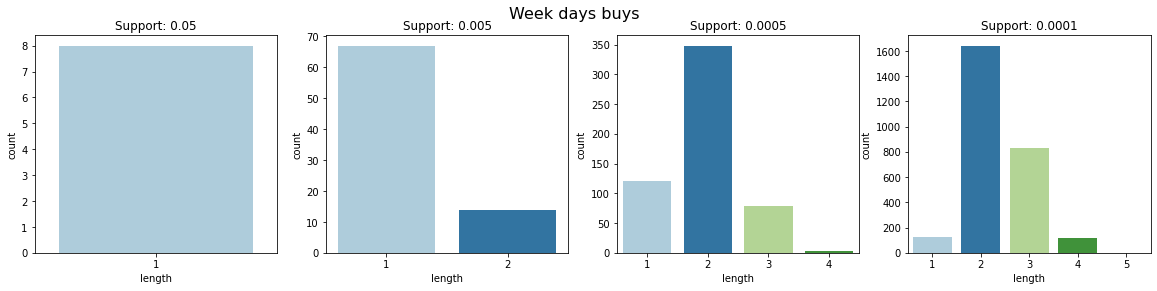

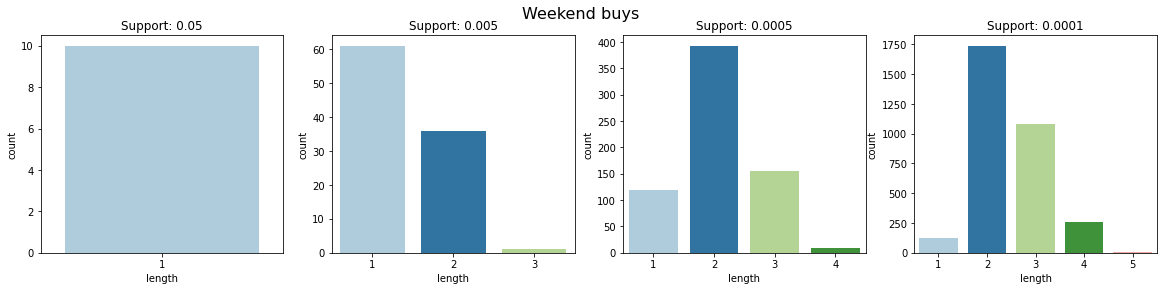

In [ ]:
X_values = [0.05,0.005,0.0005,0.0001]
sns.set_palette("Paired")

fig1, axes = plt.subplots(1,4, figsize = (20,4))
fig1.suptitle('Week days buys', fontsize=16)
for support in range(len(X_values)):
    b_week_frequent_itemsets = fpgrowth(B_week_df, min_support=X_values[support], use_colnames=True)
    b_week_frequent_itemsets['length'] = b_week_frequent_itemsets['itemsets'].apply(lambda x: len(x))
    sns.countplot(b_week_frequent_itemsets.length, ax =axes[support])
    axes[support].set_title(f'Support: {X_values[support]}');

fig2, axes = plt.subplots(1,4, figsize = (20,4))
fig2.suptitle('Weekend buys', fontsize=16)
for support in range(len(X_values)):
    b_weekend_frequent_itemsets = fpgrowth(B_weekend_df, min_support=X_values[support], use_colnames=True)
    b_weekend_frequent_itemsets['length'] = b_weekend_frequent_itemsets['itemsets'].apply(lambda x: len(x))
    sns.countplot(b_weekend_frequent_itemsets.length, ax =axes[support])
    axes[support].set_title(f'Support: {X_values[support]}');


As we can see with our first analysis:
 
*   a minimal support of 0.05 is too big for datasets of this size, because there are so many different transactions that it is highly unlikely that one itemset is present in 5% of them.
*   The second value (0.005) is better, but there are almost exclusively itemsets with only 1 item, which are not the most interesting to study patterns.
*   The third value (0.0005) looks like it's the most interesting, having itemsets of different sizes in a fair amount.
*   The last value is too low, since there are too many frequent itemsets, which end up losing interest (and becoming heavy to compute!).

The best support values to explore will be around 0.0005.



Let's compute the frequent itemsets with the decided X support and we will use Y to make the support even more selective (bigger value) for more specific analysis of the frequent itemsets, namely associated with the different lengths, as it is requested.

In [ ]:
X_b = 0.0005

In [ ]:
b_week_frequent_itemsets = fpgrowth(B_week_df, min_support=X_b, use_colnames=True)
b_week_frequent_itemsets

,support,itemsets
0,0.064574,(b_ appliances.kitchen.blender)
1,0.027237,(b_ accessories.bag)
2,0.029797,(b_ electronics.clocks)
3,0.002663,(b_ kids.skates)
4,0.031158,(b_ electronics.video.tv)
...,...,...
546,0.000624,"(b_ appliances.steam_cleaner, b_ medicine.tools.tonometer, b_ appliances.kitchen.grill)"
547,0.001688,"(b_ appliances.steam_cleaner, b_ country_yard.lawn_mower, b_ appliances.kitchen.grill)"
548,0.003950,"(b_ country_yard.lawn_mower, b_ computers.components.memory)"
549,0.014376,"(b_ country_yard.lawn_mower, b_ sport.tennis)"


In [ ]:
b_weekend_frequent_itemsets = fpgrowth(B_weekend_df, min_support=X_b, use_colnames=True)
b_weekend_frequent_itemsets

,support,itemsets
0,0.041411,(b_ appliances.kitchen.meat_grinder)
1,0.040913,(b_ appliances.environment.fan)
2,0.018782,(b_ computers.peripherals.printer)
3,0.011104,(b_ computers.components.cpu)
4,0.063680,(b_ computers.peripherals.monitor)
...,...,...
672,0.001692,"(b_ appliances.kitchen.juicer, b_ construction.tools.drill)"
673,0.001116,"(b_ appliances.kitchen.juicer, b_ appliances.steam_cleaner)"
674,0.000636,"(b_ appliances.kitchen.juicer, b_ electronics.calculator)"
675,0.000610,"(b_ appliances.kitchen.juicer, b_ appliances.steam_cleaner, b_ construction.tools.drill)"


We can already see that there are more frequent itemsets in the weekend purchases. Maybe there are more regular patterns of shopping the same items, but we still can't make a detailed analysis, as we have hundreds of itemsets with different properties.

Let's now organize them by length.

In [ ]:
# Add new column length
b_week_frequent_itemsets['length'] = b_week_frequent_itemsets['itemsets'].apply(lambda x: len(x))
b_week_frequent_itemsets.sort_values('support').sort_values('length')

,support,itemsets,length
59,0.114855,(b_ sport.tennis),1
66,0.003247,(b_ construction.tools.generator),1
112,0.003257,(b_ kids.swing),1
63,0.000658,(b_ computers.components.sound_card),1
95,0.003401,(b_ electronics.audio.microphone),1
...,...,...,...
545,0.000594,"(b_ computers.peripherals.monitor, b_ medicine.tools.tonometer, b_ appliances.kitchen.grill)",3
394,0.001931,"(b_ computers.components.memory, b_ sport.tennis, b_ appliances.environment.fan)",3
247,0.000609,"(b_ computers.components.memory, b_ sport.tennis, b_ computers.components.cpu, b_ appliances.env...",4
157,0.000594,"(b_ appliances.kitchen.toster, b_ computers.peripherals.monitor, b_ electronics.clocks, b_ compu...",4


In [ ]:
b_weekend_frequent_itemsets['length'] = b_weekend_frequent_itemsets['itemsets'].apply(lambda x: len(x))
b_weekend_frequent_itemsets.sort_values('support').sort_values('length')

,support,itemsets,length
48,0.155185,(b_ sport.tennis),1
23,0.001323,(b_ furniture.bathroom.bath),1
52,0.003890,(b_ construction.tools.heater),1
118,0.001305,(b_ construction.tools.saw),1
15,0.004277,(b_ apparel.costume),1
...,...,...,...
599,0.000636,"(b_ computers.peripherals.monitor, b_ electronics.clocks, b_ computers.components.memory, b_ spo...",4
176,0.000799,"(b_ computers.components.memory, b_ sport.tennis, b_ computers.components.cpu, b_ appliances.env...",4
569,0.000618,"(b_ appliances.steam_cleaner, b_ country_yard.lawn_mower, b_ appliances.kitchen.grill, b_ constr...",4
560,0.000507,"(b_ construction.tools.drill, b_ country_yard.lawn_mower, b_ appliances.kitchen.grill, b_ sport....",4


This is a summary of the results obtained (for each length, number of itemsets):

In [ ]:
b_week_frequent_itemsets['length'].value_counts().sort_index()

1    121
2    348
3     79
4      3
Name: length, dtype: int64

In [ ]:
b_weekend_frequent_itemsets['length'].value_counts().sort_index()

1    120
2    393
3    155
4      9
Name: length, dtype: int64

As we had already seen from the graphs, the distribution of the length of the itemsets is somewhat similar during the week and during the weekend, except that on the weekend there are more size 3 frequent itemsets than 1, which is the opposite as to what happens during the week.
Regarding the itemsets themselves, as we can see from the ordered list, there are some itemsets that are equally frequent in both categories, such as sport tennis, which are the size 1 frequent itemset with the biggest support in both.

We can now filter the results based on the desired support Y and pattern length

##### Length = 1

In [ ]:
Y_b_1 = 0.02

In [ ]:
b_week_frequent_itemsets[(b_week_frequent_itemsets['length'] == 1) & (b_week_frequent_itemsets['support'] > Y_b_1)].sort_values('support', ascending=False)

,support,itemsets,length
59,0.114855,(b_ sport.tennis),1
5,0.074420,(b_ computers.components.memory),1
119,0.064866,(b_ country_yard.lawn_mower),1
0,0.064574,(b_ appliances.kitchen.blender),1
6,0.054801,(b_ computers.gaming),1
25,0.053792,(b_ computers.peripherals.monitor),1
79,0.053133,(b_ appliances.kitchen.toster),1
45,0.051509,(b_ medicine.tools.tonometer),1
12,0.048579,(b_ appliances.steam_cleaner),1
7,0.045212,(b_ appliances.kitchen.meat_grinder),1


In [ ]:
b_weekend_frequent_itemsets[(b_weekend_frequent_itemsets['length'] == 1) & (b_weekend_frequent_itemsets['support'] > Y_b_1)].sort_values('support', ascending=False)

,support,itemsets,length
48,0.155185,(b_ sport.tennis),1
6,0.100204,(b_ computers.components.memory),1
114,0.096683,(b_ country_yard.lawn_mower),1
26,0.076673,(b_ appliances.kitchen.toster),1
67,0.068584,(b_ appliances.steam_cleaner),1
7,0.068412,(b_ appliances.kitchen.blender),1
4,0.063680,(b_ computers.peripherals.monitor),1
33,0.061301,(b_ appliances.kitchen.grill),1
13,0.058587,(b_ appliances.environment.vacuum),1
10,0.058527,(b_ medicine.tools.tonometer),1


Regarding the frequent itemsets with length 1, they are very similar between the week and the weekend.
The top 3 items are the same, with slightly bigger supports on the weekend.
One noticeble difference is the gaming, which is one of the most frequent items on the week but is not frequent on the weekend for the considered minimum support

##### Length = 2

In [ ]:
Y_b_2 = 0.005

We used a smaller support than from length 1, since the length 2 itemsets are not as frequent overall, as we can see from the support column in the following results:

In [ ]:
b_week_frequent_itemsets[(b_week_frequent_itemsets['length'] == 2) & (b_week_frequent_itemsets['support'] > Y_b_2)].sort_values('support', ascending=False)

,support,itemsets,length
549,0.014376,"(b_ country_yard.lawn_mower, b_ sport.tennis)",2
170,0.011535,"(b_ computers.components.memory, b_ sport.tennis)",2
472,0.009683,"(b_ appliances.kitchen.toster, b_ sport.tennis)",2
534,0.009203,"(b_ country_yard.lawn_mower, b_ appliances.kitchen.grill)",2
469,0.008782,"(b_ appliances.kitchen.toster, b_ computers.components.memory)",2
299,0.007955,"(b_ computers.peripherals.monitor, b_ sport.tennis)",2
121,0.007772,"(b_ computers.components.memory, b_ appliances.kitchen.blender)",2
232,0.007574,"(b_ appliances.steam_cleaner, b_ country_yard.lawn_mower)",2
376,0.007490,"(b_ computers.components.memory, b_ appliances.environment.fan)",2
471,0.007243,"(b_ appliances.kitchen.toster, b_ computers.peripherals.monitor)",2


In [ ]:
b_weekend_frequent_itemsets[(b_weekend_frequent_itemsets['length'] == 2) & (b_weekend_frequent_itemsets['support'] > Y_b_2)].sort_values('support', ascending=False)

,support,itemsets,length
666,0.027421,"(b_ country_yard.lawn_mower, b_ sport.tennis)",2
203,0.018593,"(b_ computers.components.memory, b_ sport.tennis)",2
137,0.017090,"(b_ computers.components.memory, b_ appliances.environment.fan)",2
358,0.016102,"(b_ appliances.kitchen.toster, b_ sport.tennis)",2
385,0.015536,"(b_ country_yard.lawn_mower, b_ appliances.kitchen.grill)",2
515,0.014909,"(b_ appliances.steam_cleaner, b_ country_yard.lawn_mower)",2
357,0.014462,"(b_ appliances.kitchen.toster, b_ computers.components.memory)",2
204,0.013088,"(b_ computers.components.memory, b_ appliances.kitchen.blender)",2
552,0.012315,"(b_ construction.tools.drill, b_ appliances.steam_cleaner)",2
182,0.011980,"(b_ appliances.kitchen.toster, b_ computers.peripherals.monitor)",2


Regarding the frequent itemsets with length 2, there are a lot more frequent itemsets on the weekend for the same threshold but there are no clear differences between the itemsets.
The top items are similar, with slightly larger supports on the weekend.


##### Length = 3

In [ ]:
Y_b_3 = 0.0015

We used an even smaller support than before because once again, the length 3 itemsets are not as frequent overall, as we can see from the support column in the following results:

In [ ]:
b_week_frequent_itemsets[(b_week_frequent_itemsets['length'] == 3) & (b_week_frequent_itemsets['support'] > Y_b_3)].sort_values('support', ascending=False)

,support,itemsets,length
474,0.002252,"(b_ appliances.kitchen.toster, b_ computers.components.memory, b_ sport.tennis)",3
475,0.002188,"(b_ appliances.kitchen.toster, b_ computers.peripherals.monitor, b_ sport.tennis)",3
412,0.002079,"(b_ construction.tools.drill, b_ country_yard.lawn_mower, b_ appliances.kitchen.grill)",3
394,0.001931,"(b_ computers.components.memory, b_ sport.tennis, b_ appliances.environment.fan)",3
476,0.001688,"(b_ appliances.kitchen.toster, b_ computers.peripherals.monitor, b_ computers.components.memory)",3
547,0.001688,"(b_ appliances.steam_cleaner, b_ country_yard.lawn_mower, b_ appliances.kitchen.grill)",3
303,0.001505,"(b_ computers.peripherals.monitor, b_ computers.components.memory, b_ sport.tennis)",3


In [ ]:
b_weekend_frequent_itemsets[(b_weekend_frequent_itemsets['length'] == 3) & (b_weekend_frequent_itemsets['support'] > Y_b_3)].sort_values('support', ascending=False)

,support,itemsets,length
154,0.005161,"(b_ computers.components.memory, b_ sport.tennis, b_ appliances.environment.fan)",3
189,0.004011,"(b_ appliances.kitchen.toster, b_ computers.peripherals.monitor, b_ sport.tennis)",3
360,0.003770,"(b_ appliances.kitchen.toster, b_ computers.components.memory, b_ sport.tennis)",3
567,0.003487,"(b_ construction.tools.drill, b_ country_yard.lawn_mower, b_ appliances.kitchen.grill)",3
150,0.003341,"(b_ computers.components.memory, b_ appliances.environment.fan, b_ appliances.kitchen.blender)",3
186,0.003152,"(b_ appliances.kitchen.toster, b_ computers.peripherals.monitor, b_ computers.components.memory)",3
387,0.002980,"(b_ appliances.steam_cleaner, b_ country_yard.lawn_mower, b_ appliances.kitchen.grill)",3
566,0.002765,"(b_ construction.tools.drill, b_ country_yard.lawn_mower, b_ appliances.steam_cleaner)",3
209,0.002542,"(b_ computers.components.memory, b_ sport.tennis, b_ appliances.kitchen.blender)",3
602,0.002516,"(b_ appliances.kitchen.toster, b_ computers.peripherals.monitor, b_ electronics.clocks)",3


Regarding the frequent itemsets with length 3, there are a lot more frequent itemsets on the weekend for the same threshold but there are no clear differences between the itemsets, in fact, all of the itemsets that are present on the week are also present on the weekend.



As a final conclusion from this analysis, we can say that: 

*    There are more frequent itemsets on the weekends, which means the shopping patterns are more common on the weekends and will probably mean that we will also find more rules. 
*   The frequent bought itemsets are very similar between the week and the weekend, with no observable major differences
*   The frequent itemsets contain a lot of the same items, and some of them are so frequent, like sport tennis, that they will probably show up in the association rules that will be computed in the next part.
* The most bought products are the same during the week and during the weekend, and some we consider important are these, in no particular order, since they appear a lot in the itemsets of all sizes:
* tennis, memory, toaster, fan, mower, grill and blender

#### 2.2.2 Clicked items

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

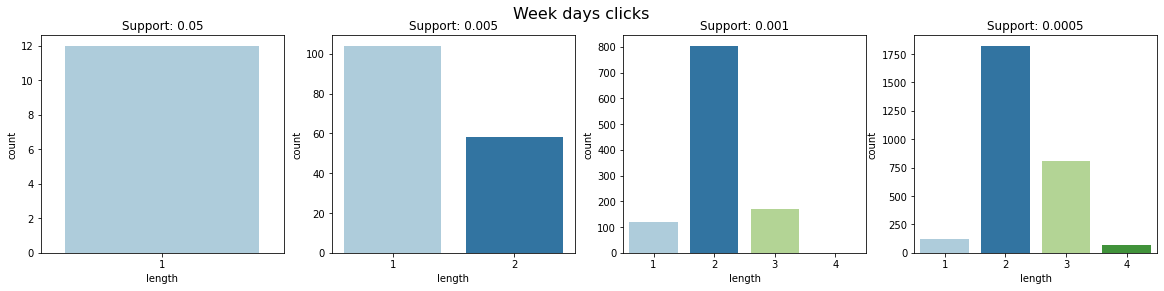

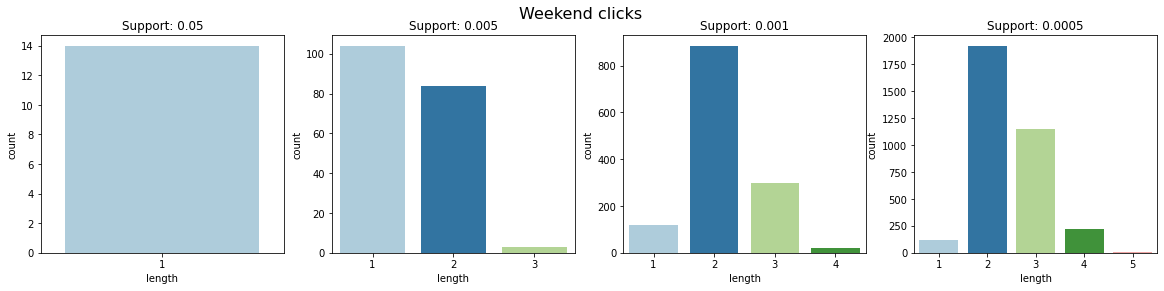

In [ ]:
X_values = [0.05,0.005,0.001,0.0005]
sns.set_palette("Paired")

fig1, axes = plt.subplots(1,4, figsize = (20,4))
fig1.suptitle('Week days clicks', fontsize=16)
for support in range(len(X_values)):
    c_week_frequent_itemsets = fpgrowth(C_week_df, min_support=X_values[support], use_colnames=True)
    c_week_frequent_itemsets['length'] = c_week_frequent_itemsets['itemsets'].apply(lambda x: len(x))
    sns.countplot(c_week_frequent_itemsets.length, ax =axes[support])
    axes[support].set_title(f'Support: {X_values[support]}');

fig2, axes = plt.subplots(1,4, figsize = (20,4))
fig2.suptitle('Weekend clicks', fontsize=16)
for support in range(len(X_values)):
    c_weekend_frequent_itemsets = fpgrowth(C_weekend_df, min_support=X_values[support], use_colnames=True)
    c_weekend_frequent_itemsets['length'] = c_weekend_frequent_itemsets['itemsets'].apply(lambda x: len(x))
    sns.countplot(c_weekend_frequent_itemsets.length, ax =axes[support])
    axes[support].set_title(f'Support: {X_values[support]}');


As we can see with our first analysis:
 
*   a minimal support of 0.05 is too big for datasets of this size, because there are so many different transactions that it is highly unlikely that one itemset is present in 5% of them.
*   The second value (0.005) is better, but it doesn't include much items with length 3.
*   The third value (0.001) looks like it's the most interesting, having itemsets of different sizes in a fair amount.
*   The last value is too low, since there are too many frequent itemsets, which end up losing interest (and becoming heavy to compute!).

The best support values to explore will be around 0.001.



Let's compute the frequent itemsets with the decided X support and we will use Y to make the support even more selective (bigger value) for more specific analysis of the frequent itemsets, namely associated with the different lengths, as it is requested.

In [ ]:
X_c = 0.001

In [ ]:
c_week_frequent_itemsets = fpgrowth(C_week_df, min_support=X_c, use_colnames=True)
c_week_frequent_itemsets

,support,itemsets
0,0.011576,(c_ electronics.audio.headphone)
1,0.010817,(c_ electronics.tablet)
2,0.026409,(c_ appliances.personal.scales)
3,0.008072,(c_ furniture.kitchen.table)
4,0.007374,(c_ electronics.smartphone)
...,...,...
1090,0.001381,"(c_ furniture.bedroom.bed, c_ sport.tennis)"
1091,0.001189,"(c_ furniture.bedroom.bed, c_ country_yard.lawn_mower)"
1092,0.001247,"(c_ stationery.battery, c_ computers.components.memory)"
1093,0.001803,"(c_ stationery.battery, c_ sport.tennis)"


In [ ]:
c_weekend_frequent_itemsets = fpgrowth(C_weekend_df, min_support=X_c, use_colnames=True)
c_weekend_frequent_itemsets

,support,itemsets
0,0.108672,(c_ computers.components.memory)
1,0.008013,(c_ appliances.kitchen.kettle)
2,0.050023,(c_ electronics.clocks)
3,0.011576,(c_ country_yard.weather_station)
4,0.094278,(c_ computers.peripherals.monitor)
...,...,...
1316,0.001131,"(c_ appliances.personal.hair_cutter, c_ computers.components.power_supply)"
1317,0.002395,"(c_ appliances.personal.hair_cutter, c_ computers.peripherals.monitor)"
1318,0.001592,"(c_ appliances.personal.hair_cutter, c_ appliances.kitchen.grill)"
1319,0.001878,"(c_ appliances.personal.hair_cutter, c_ appliances.kitchen.toster)"


We can already see that there are more frequent itemsets in the weekend clicks. Maybe there are more regular patterns of clicking on the same items on the weekends, but we still can't make a detailed analysis, as we have hundreds of itemsets with different properties.

Let's now organize them by length

In [ ]:
# Add new column length
c_week_frequent_itemsets['length'] = c_week_frequent_itemsets['itemsets'].apply(lambda x: len(x))
c_week_frequent_itemsets.sort_values('support').sort_values('length')

,support,itemsets,length
67,0.144613,(c_ sport.tennis),1
107,0.007240,(c_ apparel.shoes),1
82,0.007283,(c_ kids.swing),1
4,0.007374,(c_ electronics.smartphone),1
97,0.007603,(c_ furniture.living_room.cabinet),1
...,...,...,...
468,0.001131,"(c_ appliances.kitchen.grill, c_ appliances.kitchen.toster, c_ computers.peripherals.monitor)",3
461,0.001396,"(c_ sport.tennis, c_ appliances.kitchen.grill, c_ appliances.kitchen.toster)",3
295,0.001122,"(c_ appliances.iron, c_ country_yard.lawn_mower, c_ appliances.kitchen.grill)",3
529,0.001589,"(c_ computers.components.memory, c_ appliances.kitchen.blender, c_ appliances.kitchen.meat_grinder)",3


In [ ]:
c_weekend_frequent_itemsets['length'] = c_weekend_frequent_itemsets['itemsets'].apply(lambda x: len(x))
c_weekend_frequent_itemsets.sort_values('support').sort_values('length')

,support,itemsets,length
38,0.159479,(c_ sport.tennis),1
28,0.007540,(c_ furniture.living_room.cabinet),1
103,0.007564,(c_ apparel.costume),1
0,0.108672,(c_ computers.components.memory),1
82,0.002286,(c_ appliances.kitchen.refrigerators),1
...,...,...,...
514,0.001087,"(c_ appliances.iron, c_ sport.tennis, c_ country_yard.lawn_mower, c_ appliances.kitchen.toster)",4
792,0.001242,"(c_ medicine.tools.tonometer, c_ sport.tennis, c_ computers.components.memory, c_ computers.peri...",4
147,0.001240,"(c_ sport.tennis, c_ electronics.clocks, c_ appliances.kitchen.toster, c_ computers.peripherals....",4
152,0.001319,"(c_ sport.tennis, c_ electronics.clocks, c_ computers.components.memory, c_ computers.peripheral...",4


This is a summary of the results obtained (for each length, number of itemsets):

In [ ]:
c_week_frequent_itemsets['length'].value_counts().sort_index()

1    121
2    804
3    169
4      1
Name: length, dtype: int64

In [ ]:
c_weekend_frequent_itemsets['length'].value_counts().sort_index()

1    120
2    885
3    297
4     19
Name: length, dtype: int64

As we had already seen from the graphs, the distribution of the length of the itemsets is somewhat similar during the week and during the weekend, except that on the weekend there are more size 3 frequent itemsets than 1, which is the opposite as to what happens during the week.
Regarding the itemsets themselves, as we can see from the ordered list, there are some itemsets that are equally frequent in both categories, such as sport tennis, which are the size 1 frequent itemset with the biggest support in both.

We can now filter the results based on the desired support Y and pattern length

##### Length = 1

In [ ]:
Y_c_1 = 0.04

In [ ]:
c_week_frequent_itemsets[(c_week_frequent_itemsets['length'] == 1) & (c_week_frequent_itemsets['support'] > Y_c_1)].sort_values('support', ascending=False)

,support,itemsets,length
67,0.144613,(c_ sport.tennis),1
11,0.091879,(c_ computers.components.memory),1
9,0.084738,(c_ computers.peripherals.monitor),1
31,0.078045,(c_ appliances.kitchen.toster),1
46,0.072455,(c_ medicine.tools.tonometer),1
59,0.066620,(c_ country_yard.lawn_mower),1
12,0.065425,(c_ appliances.kitchen.blender),1
69,0.060111,(c_ appliances.steam_cleaner),1
29,0.058192,(c_ appliances.kitchen.grill),1
35,0.056925,(c_ appliances.kitchen.meat_grinder),1


In [ ]:
c_weekend_frequent_itemsets[(c_weekend_frequent_itemsets['length'] == 1) & (c_weekend_frequent_itemsets['support'] > Y_c_1)].sort_values('support', ascending=False)

,support,itemsets,length
38,0.159479,(c_ sport.tennis),1
0,0.108672,(c_ computers.components.memory),1
4,0.094278,(c_ computers.peripherals.monitor),1
30,0.093480,(c_ appliances.kitchen.toster),1
53,0.077376,(c_ medicine.tools.tonometer),1
116,0.076485,(c_ country_yard.lawn_mower),1
75,0.070799,(c_ appliances.steam_cleaner),1
7,0.067576,(c_ appliances.environment.vacuum),1
73,0.066992,(c_ appliances.kitchen.grill),1
8,0.059307,(c_ appliances.kitchen.blender),1


Regarding the frequent itemsets with length 1, they are very similar between the week and the weekend.
The top 6 items are the same, with slight bigger supports on the weekend.

##### Length = 2

In [ ]:
Y_c_2 = 0.01

We used a smaller support than from length 1, since the length 2 itemsets are not as frequent overall, as we can see from the support column in the following results:

In [ ]:
c_week_frequent_itemsets[(c_week_frequent_itemsets['length'] == 2) & (c_week_frequent_itemsets['support'] > Y_c_2)].sort_values('support', ascending=False)

,support,itemsets,length
232,0.019448,"(c_ sport.tennis, c_ computers.components.memory)",2
209,0.015926,"(c_ sport.tennis, c_ computers.peripherals.monitor)",2
479,0.014980,"(c_ sport.tennis, c_ appliances.kitchen.toster)",2
650,0.012738,"(c_ medicine.tools.tonometer, c_ sport.tennis)",2
737,0.012062,"(c_ country_yard.lawn_mower, c_ sport.tennis)",2
477,0.011640,"(c_ appliances.kitchen.toster, c_ computers.peripherals.monitor)",2
478,0.011327,"(c_ computers.components.memory, c_ appliances.kitchen.toster)",2
145,0.011170,"(c_ sport.tennis, c_ computers.notebook)",2
233,0.010817,"(c_ computers.components.memory, c_ appliances.kitchen.blender)",2
521,0.010136,"(c_ sport.tennis, c_ appliances.kitchen.meat_grinder)",2


In [ ]:
c_weekend_frequent_itemsets[(c_weekend_frequent_itemsets['length'] == 2) & (c_weekend_frequent_itemsets['support'] > Y_c_2)].sort_values('support', ascending=False)

,support,itemsets,length
120,0.026042,"(c_ sport.tennis, c_ computers.components.memory)",2
615,0.020757,"(c_ sport.tennis, c_ appliances.kitchen.toster)",2
175,0.019929,"(c_ sport.tennis, c_ computers.peripherals.monitor)",2
1280,0.017923,"(c_ country_yard.lawn_mower, c_ sport.tennis)",2
614,0.015938,"(c_ appliances.kitchen.toster, c_ computers.peripherals.monitor)",2
616,0.015554,"(c_ computers.components.memory, c_ appliances.kitchen.toster)",2
788,0.015067,"(c_ medicine.tools.tonometer, c_ sport.tennis)",2
1142,0.013224,"(c_ sport.tennis, c_ computers.notebook)",2
249,0.013040,"(c_ computers.components.memory, c_ appliances.kitchen.blender)",2
1207,0.012949,"(c_ appliances.steam_cleaner, c_ construction.tools.drill)",2


Regarding the frequent itemsets with length 2, there are no clear differences between the itemsets. All of the computed frequent itmsets of the week are contained in the frequent itemsets of the weekends, with slight different supports.


##### Length = 3

In [ ]:
Y_c_3 = 0.002

We used an even smaller support than from before because one again, the length 3 itemsets are not as frequent overall, as we can see from the support column in the following results:

In [ ]:
c_week_frequent_itemsets[(c_week_frequent_itemsets['length'] == 3) & (c_week_frequent_itemsets['support'] > Y_c_3)].sort_values('support', ascending=False)

,support,itemsets,length
482,0.003474,"(c_ sport.tennis, c_ computers.components.memory, c_ appliances.kitchen.toster)",3
480,0.003353,"(c_ sport.tennis, c_ appliances.kitchen.toster, c_ computers.peripherals.monitor)",3
210,0.003252,"(c_ sport.tennis, c_ computers.components.memory, c_ computers.peripherals.monitor)",3
651,0.003014,"(c_ medicine.tools.tonometer, c_ sport.tennis, c_ computers.peripherals.monitor)",3
239,0.002869,"(c_ sport.tennis, c_ computers.components.memory, c_ appliances.kitchen.blender)",3
884,0.002790,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.memory)",3
154,0.002501,"(c_ sport.tennis, c_ computers.components.memory, c_ computers.notebook)",3
656,0.002461,"(c_ medicine.tools.tonometer, c_ sport.tennis, c_ computers.components.memory)",3
744,0.002447,"(c_ sport.tennis, c_ country_yard.lawn_mower, c_ appliances.kitchen.toster)",3
481,0.002383,"(c_ computers.components.memory, c_ appliances.kitchen.toster, c_ computers.peripherals.monitor)",3


In [ ]:
c_weekend_frequent_itemsets[(c_weekend_frequent_itemsets['length'] == 3) & (c_weekend_frequent_itemsets['support'] > Y_c_3)].sort_values('support', ascending=False)

,support,itemsets,length
619,0.005460,"(c_ sport.tennis, c_ computers.components.memory, c_ appliances.kitchen.toster)",3
617,0.005220,"(c_ sport.tennis, c_ appliances.kitchen.toster, c_ computers.peripherals.monitor)",3
442,0.005010,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.memory)",3
176,0.004496,"(c_ sport.tennis, c_ computers.components.memory, c_ computers.peripherals.monitor)",3
798,0.004264,"(c_ medicine.tools.tonometer, c_ sport.tennis, c_ computers.peripherals.monitor)",3
1290,0.003933,"(c_ sport.tennis, c_ country_yard.lawn_mower, c_ appliances.kitchen.toster)",3
257,0.003897,"(c_ sport.tennis, c_ computers.components.memory, c_ appliances.kitchen.blender)",3
618,0.003736,"(c_ computers.components.memory, c_ appliances.kitchen.toster, c_ computers.peripherals.monitor)",3
1283,0.003491,"(c_ sport.tennis, c_ country_yard.lawn_mower, c_ computers.components.memory)",3
983,0.003412,"(c_ medicine.tools.tonometer, c_ appliances.kitchen.grill, c_ sport.tennis)",3


Regarding the frequent itemsets with length 3, there are a lot more frequent itemsets on the weekend for the same threshold, but there are no clear differences between the itemsets.

As a final conclusion from this analysis, we can say that: 

*    There are more frequent itemsets on the weekends, which means the clicking patterns are more common on the weekends and will probably mean that we will also find more rules. 
*   The frequent clicked itemsets are very similar between the week and the weekend, with no observable major differences
*   The frequent itemsets contain a lot of the same items, and some of them are so frequent, like sport tennis, that they will probably show up in the association rules that will be computed in the next part.
* We consider the most clicked items as the ones which appear a lot in the frequent itemsets of all sizes, which are very similar for the week and for the weekend, and some of them are:
tennis, memory, monitor, toaster and tonometer.

#### 2.2.3 Clicked and Bought items

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

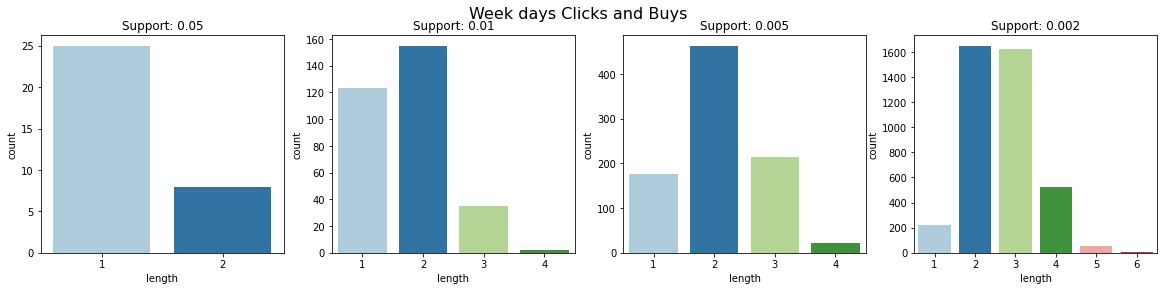

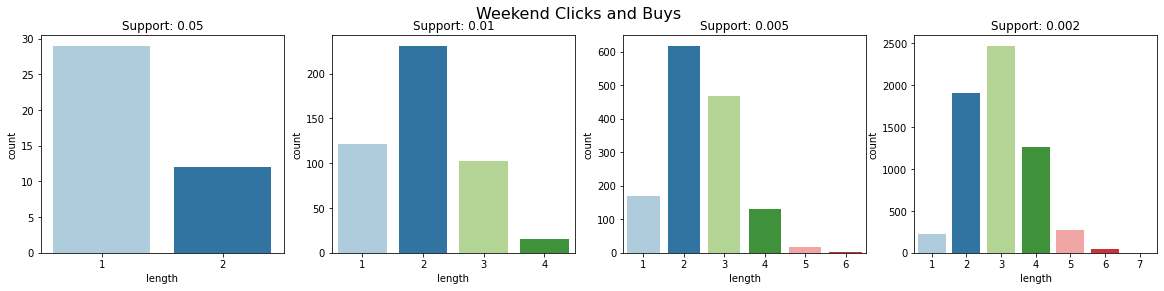

In [ ]:
X_values = [0.05, 0.01, 0.005, 0.002]
sns.set_palette("Paired")

fig1, axes = plt.subplots(1,4, figsize = (20,4))
fig1.suptitle('Week days Clicks and Buys \n', fontsize=16)
for support in range(len(X_values)):
    cb_week_frequent_itemsets = fpgrowth(CB_week_df, min_support=X_values[support], use_colnames=True)
    cb_week_frequent_itemsets['length'] = cb_week_frequent_itemsets['itemsets'].apply(lambda x: len(x))
    sns.countplot(cb_week_frequent_itemsets.length, ax =axes[support])
    axes[support].set_title(f'Support: {X_values[support]}');

fig2, axes = plt.subplots(1,4, figsize = (20,4))
fig2.suptitle('Weekend Clicks and Buys \n', fontsize=16)
for support in range(len(X_values)):
    cb_weekend_frequent_itemsets = fpgrowth(CB_weekend_df, min_support=X_values[support], use_colnames=True)
    cb_weekend_frequent_itemsets['length'] = cb_weekend_frequent_itemsets['itemsets'].apply(lambda x: len(x))
    sns.countplot(cb_weekend_frequent_itemsets.length, ax =axes[support])
    axes[support].set_title(f'Support: {X_values[support]}');


As we can see with our first analysis:
 
*   a minimal support of 0.05 is too big for datasets of this size, because there are so many different transactions that it is highly unlikely that one itemset is present in 5% of them.
*   The second value (0.01) is better, having itemsets with various sizes.
*   The third value (0.005) is also interesting, having a lot of itemsets of different sizes.
*   The last value is too low, since there are too many frequent itemsets, which end up losing interest (and becoming heavy to compute!).

The best support values to explore will be around 0.005.



Let's compute the frequent itemsets with the decided X support and we will use Y to make the support even more selective (bigger value) for more specific analysis of the frequent itemsets, namely associated with the different lengths, as it is requested.

In [ ]:
X_cb = 0.005

In [ ]:
cb_week_frequent_itemsets = fpgrowth(CB_week_df, min_support=X_cb, use_colnames=True)
cb_week_frequent_itemsets

,support,itemsets
0,0.128958,(c_ computers.components.memory)
1,0.101485,(c_ appliances.kitchen.blender)
2,0.067135,(c_ appliances.iron)
3,0.067081,(c_ accessories.bag)
4,0.064575,(b_ appliances.kitchen.blender)
...,...,...
870,0.014363,"(b_ country_yard.lawn_mower, b_ sport.tennis, c_ sport.tennis, c_ country_yard.lawn_mower)"
871,0.007704,"(c_ medicine.tools.tonometer, b_ country_yard.lawn_mower, c_ country_yard.lawn_mower)"
872,0.005357,"(c_ appliances.environment.vacuum, b_ country_yard.lawn_mower, c_ country_yard.lawn_mower)"
873,0.013962,"(b_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ country_yard.lawn_mower)"


In [ ]:
cb_weekend_frequent_itemsets = fpgrowth(CB_weekend_df, min_support=X_cb, use_colnames=True)
cb_weekend_frequent_itemsets

,support,itemsets
0,0.077712,(c_ appliances.kitchen.meat_grinder)
1,0.061556,(c_ appliances.environment.fan)
2,0.041407,(b_ appliances.kitchen.meat_grinder)
3,0.040909,(b_ appliances.environment.fan)
4,0.040428,(c_ computers.peripherals.printer)
...,...,...
1401,0.005849,"(b_ country_yard.lawn_mower, c_ appliances.kitchen.grill, c_ sport.tennis, c_ country_yard.lawn_..."
1402,0.021283,"(b_ country_yard.lawn_mower, c_ appliances.steam_cleaner, c_ country_yard.lawn_mower)"
1403,0.007361,"(b_ country_yard.lawn_mower, c_ appliances.steam_cleaner, c_ appliances.kitchen.grill)"
1404,0.007361,"(b_ country_yard.lawn_mower, c_ appliances.steam_cleaner, c_ appliances.kitchen.grill, c_ countr..."


We will not explore the clicks and buys frequent itemsets in more depth, since the main focus for this dataset are the association rules.

### 2.3. Generate Association Rules from Frequent Itemsets

* Generate association rules with a choosed value (C) for minimum confidence. 
* Generate association rules with a choosed value (L) for minimum lift. 
* Generate association rules with both confidence >= C% and lift >= L.
* Change C and L when it makes sense and discuss the results.

As for the first part, a lot of experiences and variations of confidence and lift were made, but only the more relevant ones will be presented. A more complete analysis will be done on the clicked and bought, since there was more emphasis on this part in the initial questions.

#### 2.3.1 Bought items

First let's compute the frequent itemsets with a support slightly inferior to the one used for the frequent itemsets, becuase we want to have more itemset options for the rules.

In [ ]:
b_week_frequent_itemsets = fpgrowth(B_week_df, min_support=0.0002, use_colnames=True)
b_weekend_frequent_itemsets = fpgrowth(B_weekend_df, min_support=0.0002, use_colnames=True)

There were a lot of different combinations of values for confidence and lift used, but we will present the result for what we considered the best ones.
The confidence could not be much higher than 0.5/0.6, otherwise it would be too restrictive, so we chose 0.3 which was a good balance of good confidence (given the size of the dataset) and a good number of rules.
The lift shoul be higher than 1 to represent dependency, and since there were some high values of lift in the rules, we chose a lift of 3, once again to garantee that there was dependency, but without being too restrictive, so we would have a good "sample" of rules.

In [ ]:
C = 0.3
L = 3

First, the association rules for the minimum confidence were generated, then for the chosen lift value, but for a more summarized analysis, since there are still a lot of rules which individually satisty each condition, we will only present the rules which already satisty both conditions.

In [ ]:
b_week_rules_conf = association_rules(b_week_frequent_itemsets, metric="confidence", min_threshold=C)
b_week_rules_lift = association_rules(b_week_frequent_itemsets, metric="lift", min_threshold=L)

Since there were still a lot of rules, we decided to also filter by minimum support and filter the final rules by lift, since we consider it a good measure.

In [ ]:
b_week_rules = b_week_rules_lift[(b_week_rules_lift.confidence >= C) & (b_week_rules_lift.support >= 0.0005)]
b_week_rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
379,"(b_ computers.components.memory, b_ computers.components.cpu)","(b_ appliances.environment.fan, b_ sport.tennis)",0.001886,0.004574,0.000609,0.322835,70.577104,0.000600,1.469989
773,"(b_ computers.peripherals.printer, b_ computers.peripherals.camera)",(b_ furniture.bedroom.blanket),0.001297,0.007995,0.000629,0.484733,60.629721,0.000618,1.925225
817,"(b_ computers.peripherals.camera, b_ computers.components.hdd)",(b_ furniture.bedroom.blanket),0.002223,0.007995,0.000827,0.371938,46.521453,0.000809,1.579469
381,"(b_ sport.tennis, b_ computers.components.cpu)","(b_ computers.components.memory, b_ appliances.environment.fan)",0.001871,0.007490,0.000609,0.325397,43.444025,0.000595,1.471250
779,"(b_ computers.peripherals.printer, b_ computers.components.hdd)",(b_ furniture.bedroom.blanket),0.001668,0.007995,0.000569,0.341246,42.682621,0.000556,1.505882
818,"(b_ furniture.bedroom.blanket, b_ computers.components.hdd)",(b_ computers.peripherals.camera),0.001842,0.011436,0.000827,0.448925,39.257010,0.000806,1.793883
774,"(b_ computers.peripherals.printer, b_ furniture.bedroom.blanket)",(b_ computers.peripherals.camera),0.001421,0.011436,0.000629,0.442509,38.695950,0.000612,1.773238
374,"(b_ computers.components.memory, b_ sport.tennis, b_ computers.components.cpu)",(b_ appliances.environment.fan),0.000807,0.024416,0.000609,0.754601,30.906520,0.000589,3.975506
375,"(b_ computers.components.memory, b_ sport.tennis, b_ appliances.environment.fan)",(b_ computers.components.cpu),0.001931,0.011025,0.000609,0.315385,28.607240,0.000588,1.444571
356,"(b_ computers.components.memory, b_ computers.components.cpu)",(b_ appliances.environment.fan),0.001886,0.024416,0.001292,0.685039,28.057446,0.001246,3.097480


In [ ]:
b_weekend_rules_conf = association_rules(b_weekend_frequent_itemsets, metric="confidence", min_threshold=C)
b_weekend_rules_lift = association_rules(b_weekend_frequent_itemsets, metric="lift", min_threshold=L)

Since there are more rules on the weekend, for the same criteria, we are going to limit the results to the first 50 for easy comparing, since that is around the number of rules generated for the week.

In [ ]:
b_weekend_rules = b_weekend_rules_lift[(b_weekend_rules_lift.confidence >= C) & (b_weekend_rules_lift.support >= 0.0005)]
b_weekend_rules.sort_values('lift', ascending=False).head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1507,"(b_ computers.peripherals.printer, b_ computers.peripherals.camera)",(b_ furniture.bedroom.blanket),0.000910,0.006888,0.000507,0.556604,80.813038,0.000500,2.239786
1508,"(b_ computers.peripherals.printer, b_ furniture.bedroom.blanket)",(b_ computers.peripherals.camera),0.001013,0.009361,0.000507,0.500000,53.413761,0.000497,1.981278
1501,"(b_ computers.peripherals.camera, b_ computers.components.hdd)",(b_ furniture.bedroom.blanket),0.001657,0.006888,0.000593,0.357513,51.907136,0.000581,1.545731
1502,"(b_ furniture.bedroom.blanket, b_ computers.components.hdd)",(b_ computers.peripherals.camera),0.001357,0.009361,0.000593,0.436709,46.652526,0.000580,1.758663
131,"(b_ computers.components.memory, b_ computers.components.cpu)","(b_ appliances.environment.fan, b_ sport.tennis)",0.001967,0.009876,0.000799,0.406114,41.120585,0.000779,1.667194
133,"(b_ sport.tennis, b_ computers.components.cpu)","(b_ computers.components.memory, b_ appliances.environment.fan)",0.001864,0.017090,0.000799,0.428571,25.077243,0.000767,1.720092
737,(b_ furniture.kitchen.table),(b_ computers.components.videocards),0.005213,0.021066,0.002654,0.509061,24.164727,0.002544,1.994003
126,"(b_ computers.components.memory, b_ sport.tennis, b_ computers.components.cpu)",(b_ appliances.environment.fan),0.000962,0.040913,0.000799,0.830357,20.295644,0.000759,5.653565
135,"(b_ appliances.environment.fan, b_ computers.components.cpu)","(b_ computers.components.memory, b_ sport.tennis)",0.002130,0.018593,0.000799,0.375000,20.168938,0.000759,1.570251
140,"(b_ computers.components.memory, b_ computers.components.cpu)",(b_ appliances.environment.fan),0.001967,0.040913,0.001417,0.720524,17.611095,0.001337,3.431733


As we expected, the items which were very frequent (such as tennis and memory) are present in a lot of rules.

We found rules with extremely high values of lift, which means they are significant, even if they don't seem to make that much sense to us. For example, one of the rules with the highest lift, both on the week and weekend is a mix of different categories:

* cpu, memory => tennis, fan

It is interesting to note that even though 'blanket' was not among the most frequent itemsets, it is present in the top rules both during the week and weekend:

* camera, printer => blanket
* hdd, camera =>	blanket

As we can see from the examples above, there are similarities between the rules generated for the week and for the weekend, but there are also some differences.

There are more rules with high lift with hdd as consequent on the week, such as:

* blanket, printer => hdd; 
* camera, printer => hdd
* blanket, camera => hdd, with lifts around 16

There are more rules with high lift with drill as a consequent on the weekends, such as:

steam_cleaner, juicer => drill, with lift 13

These differences seem to make sense, as an hdd would be more necessary to work (during the week) and the drill to make house work (during the weekend).

#### 2.3.2 Clicked items

This analysis was performed in the same way as for the bought items.

In [ ]:
c_week_frequent_itemsets = fpgrowth(C_week_df, min_support=0.0008, use_colnames=True)
c_weekend_frequent_itemsets = fpgrowth(C_weekend_df, min_support=0.0008, use_colnames=True)

In [ ]:
C = 0.3
L = 3

In [ ]:
c_week_rules_conf = association_rules(c_week_frequent_itemsets, metric="confidence", min_threshold=C)
c_week_rules_lift = association_rules(c_week_frequent_itemsets, metric="lift", min_threshold=L)

In [ ]:
c_week_rules = c_week_rules_lift[(c_week_rules_lift.confidence >= C) & (c_week_rules_lift.support >= 0.0005)]
c_week_rules.sort_values('lift', ascending= False).head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
770,"(c_ computers.peripherals.camera, c_ computers.peripherals.printer)",(c_ furniture.bedroom.blanket),0.002282,0.013492,0.001138,0.498621,36.956752,0.001107,1.967589
758,"(c_ computers.peripherals.camera, c_ computers.components.hdd)",(c_ furniture.bedroom.blanket),0.004586,0.013492,0.001933,0.421546,31.244128,0.001871,1.705422
782,"(c_ appliances.environment.vacuum, c_ computers.peripherals.camera)",(c_ furniture.bedroom.blanket),0.002134,0.013492,0.000884,0.414280,30.705605,0.000855,1.684267
760,"(c_ computers.components.hdd, c_ furniture.bedroom.blanket)",(c_ computers.peripherals.camera),0.003156,0.020669,0.001933,0.612496,29.632980,0.001868,2.527278
788,"(c_ computers.peripherals.camera, c_ electronics.clocks)",(c_ furniture.bedroom.blanket),0.002069,0.013492,0.000812,0.392219,29.070455,0.000784,1.623131
789,"(c_ electronics.clocks, c_ furniture.bedroom.blanket)",(c_ computers.peripherals.camera),0.001427,0.020669,0.000812,0.568620,27.510247,0.000782,2.270228
772,"(c_ computers.peripherals.printer, c_ furniture.bedroom.blanket)",(c_ computers.peripherals.camera),0.002023,0.020669,0.001138,0.562484,27.213361,0.001096,2.238387
783,"(c_ appliances.environment.vacuum, c_ furniture.bedroom.blanket)",(c_ computers.peripherals.camera),0.001880,0.020669,0.000884,0.470219,22.749526,0.000845,1.848557
116,"(c_ computers.components.cpu, c_ computers.components.memory, c_ sport.tennis)",(c_ appliances.environment.fan),0.001427,0.030197,0.000820,0.574816,19.035745,0.000777,2.280904
514,"(c_ computers.components.hdd, c_ electronics.clocks)",(c_ computers.peripherals.camera),0.002106,0.020669,0.000821,0.389816,18.859559,0.000778,1.604975


In [ ]:
c_weekend_rules_conf = association_rules(c_weekend_frequent_itemsets, metric="confidence", min_threshold=C)
c_weekend_rules_lift = association_rules(c_weekend_frequent_itemsets, metric="lift", min_threshold=L)

In [ ]:
c_weekend_rules = c_weekend_rules_lift[(c_weekend_rules_lift.confidence >= C) & (c_weekend_rules_lift.support >= 0.0005)]
c_weekend_rules.sort_values('lift', ascending= False).head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1480,"(c_ computers.peripherals.camera, c_ computers.peripherals.printer)",(c_ furniture.bedroom.blanket),0.002097,0.012972,0.001019,0.485971,37.462560,0.000992,1.920181
1111,"(c_ computers.components.cpu, c_ computers.components.memory)","(c_ appliances.environment.fan, c_ sport.tennis)",0.004501,0.009886,0.001658,0.368324,37.257179,0.001613,1.567439
1492,"(c_ computers.peripherals.camera, c_ computers.components.hdd)",(c_ furniture.bedroom.blanket),0.003892,0.012972,0.001709,0.439024,33.843508,0.001658,1.759484
1494,"(c_ computers.components.hdd, c_ furniture.bedroom.blanket)",(c_ computers.peripherals.camera),0.002928,0.017847,0.001709,0.583618,32.700857,0.001657,2.358777
1468,"(c_ appliances.environment.vacuum, c_ computers.peripherals.camera)",(c_ furniture.bedroom.blanket),0.002048,0.012972,0.000826,0.403361,31.094316,0.000800,1.654314
1482,"(c_ computers.peripherals.printer, c_ furniture.bedroom.blanket)",(c_ computers.peripherals.camera),0.001919,0.017847,0.001019,0.531096,29.758014,0.000985,2.094573
1107,"(c_ computers.components.cpu, c_ sport.tennis)","(c_ appliances.environment.fan, c_ computers.components.memory)",0.005091,0.012767,0.001658,0.325592,25.503038,0.001593,1.463851
1469,"(c_ appliances.environment.vacuum, c_ furniture.bedroom.blanket)",(c_ computers.peripherals.camera),0.001945,0.017847,0.000826,0.424658,23.794111,0.000791,1.707075
1104,"(c_ computers.components.cpu, c_ computers.components.memory, c_ sport.tennis)",(c_ appliances.environment.fan),0.002428,0.037306,0.001658,0.682670,18.299206,0.001567,3.033735
1103,"(c_ computers.components.memory, c_ appliances.environment.fan, c_ sport.tennis)",(c_ computers.components.cpu),0.005010,0.018589,0.001658,0.330895,17.800184,0.001565,1.466752


As we expected, the items which were very frequent (such as tennis and memory) are present in a lot of rules.

We found rules with extremely high values of lift, which means they are significant, even if they don't always seem to make that much sense to us. For example, the rule with the highest lift:

* camera, printer => blanket

It is interesting to note that even though 'blanket' and 'camera' were not among the most frequent clicked itemsets, they are present as antecedents and consequents in the top rules both during the week and weekend, such as the top one, mentioned before and:

* blanket, hdd => camera, with lifts around 30

As we can see from the examples above and by the overall results, there are a lot of similarities between the rules generated for the week and for the weekend clicks, but there are also some differences.

For example, there are more rules with high lift with tonometer as consequent on the weekend, such as:

* grill, power_supply, tennis => tonometer, with lift 8.9

Even though it is a somewhat strange rule.



#### 2.3.3 Clicked and Bought items

First, let's create a function that allows filtering only the rules that have only clicked items as antecedents and only bought items as consequents, since these are the rules we are interested in.

In [ ]:
def filter_clicks_buys(antecedents, consequents):
    c = True
    for item in antecedents:
    if item.startswith('b_'):
        c = False
    b = True
    for item in consequents:
        if item.startswith('c_'):
            b = False
    return c and b

Let's compute the frequent itemsets with a smaller minumum support than the one used for the frequent itemsets.

In [ ]:
cb_week_frequent_itemsets = fpgrowth(CB_week_df, min_support=0.002, use_colnames=True)
cb_weekend_frequent_itemsets = fpgrowth(CB_weekend_df, min_support=0.002, use_colnames=True)

For this section, as mentioned before, we will do a more complete analysis, changing first the confidence, then the lift and then use both.

#### Testing confidence

In [ ]:
C = 0.70

In [ ]:
cb_week_rules_conf = association_rules(cb_week_frequent_itemsets, metric="confidence", min_threshold=C)
cb_week_rules_conf[cb_week_rules_conf.apply(lambda x: filter_clicks_buys(x.antecedents, x.consequents), axis=1)].sort_values('confidence', ascending= False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
235,(c_ computers.gaming),(b_ computers.gaming),0.061125,0.054807,0.054807,0.896647,16.360036,0.051457,9.145259
613,"(c_ furniture.kitchen.table, c_ computers.components.videocards)",(b_ computers.components.videocards),0.006090,0.023324,0.005342,0.877236,37.610902,0.005200,7.955705
500,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ computers.components.memory)",(b_ appliances.environment.fan),0.003693,0.024418,0.002951,0.798928,32.718613,0.002861,4.851894
514,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ sport.tennis)",(b_ appliances.environment.fan),0.003040,0.024418,0.002322,0.763844,31.281813,0.002248,4.131085
496,"(c_ computers.components.cpu, c_ appliances.environment.fan)",(b_ appliances.environment.fan),0.005025,0.024418,0.003728,0.741872,30.382002,0.003605,3.779449
494,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ computers.components.memory)",(b_ computers.components.memory),0.003693,0.074418,0.002718,0.735925,9.889086,0.002443,3.504996
949,"(c_ country_yard.lawn_mower, c_ construction.tools.drill, c_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.006411,0.064867,0.004555,0.710425,10.951938,0.004139,3.229324


In [ ]:
cb_weekend_rules_conf = association_rules(cb_weekend_frequent_itemsets, metric="confidence", min_threshold=C)
cb_weekend_rules_conf[cb_weekend_rules_conf.apply(lambda x: filter_clicks_buys(x.antecedents, x.consequents), axis=1)].sort_values('confidence', ascending= False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
829,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ computers.components.memory, c_ ...",(b_ appliances.environment.fan),0.006029,0.040909,0.005402,0.896011,21.902710,0.005156,9.223042
817,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ computers.components.memory)",(b_ appliances.environment.fan),0.008254,0.040909,0.007395,0.895942,21.901007,0.007057,9.216867
822,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ sport.tennis)",(b_ appliances.environment.fan),0.007129,0.040909,0.006236,0.874699,21.381730,0.005944,7.654286
754,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ computers.components.memory, c_ ...",(b_ appliances.environment.fan),0.003393,0.040909,0.002955,0.870886,21.288529,0.002816,7.428256
749,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ appliances.kitchen.blender)",(b_ appliances.environment.fan),0.003805,0.040909,0.003307,0.869074,21.244246,0.003151,7.325473
812,"(c_ computers.components.cpu, c_ appliances.environment.fan)",(b_ appliances.environment.fan),0.010169,0.040909,0.008786,0.864020,21.120697,0.008370,7.053193
758,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ sport.tennis, c_ appliances.kitc...",(b_ appliances.environment.fan),0.002912,0.040909,0.002508,0.861357,21.055593,0.002389,6.917701
766,"(c_ computers.components.cpu, c_ appliances.environment.fan, c_ sport.tennis, c_ appliances.kitc...",(b_ appliances.environment.fan),0.002637,0.040909,0.002259,0.856678,20.941206,0.002151,6.691842
2146,"(c_ furniture.kitchen.table, c_ computers.components.videocards)",(b_ computers.components.videocards),0.005274,0.021068,0.004372,0.828990,39.347465,0.004261,5.724419
400,"(c_ sport.tennis, c_ appliances.environment.fan, c_ computers.components.memory)",(b_ appliances.environment.fan),0.016697,0.040909,0.012840,0.769033,18.798762,0.012157,4.152502


We can see that even for a high threshold of confidence we have some rules, both on the week and (specially) on the weekend. However, they are mostly rules of the same "kind" with a high number of itemsets as antecedents and only one consequents are generated, which limits our analysis. We will be interested in lowering this threshold so we can generate some more interesting rules.


#### Testing lift

In [ ]:
L = 100

In [ ]:
cb_week_rules_lift = association_rules(cb_week_frequent_itemsets, metric="lift", min_threshold=L)
cb_week_rules_lift[cb_week_rules_lift.apply(lambda x: filter_clicks_buys(x.antecedents, x.consequents), axis=1)].sort_values('lift', ascending= False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
153,(c_ electronics.camera.photo),(b_ electronics.camera.photo),0.004352,0.002416,0.002416,0.555176,229.784983,0.002406,2.242650
20,"(c_ computers.components.cpu, c_ appliances.environment.fan)","(b_ appliances.environment.fan, b_ computers.components.cpu)",0.005025,0.002055,0.002050,0.407882,198.516551,0.002039,1.685382
97,(c_ appliances.sewing_machine),(b_ appliances.sewing_machine),0.005525,0.002649,0.002649,0.479391,180.986559,0.002634,1.915738
36,"(c_ furniture.kitchen.table, c_ computers.components.videocards)","(b_ computers.components.videocards, b_ furniture.kitchen.table)",0.006090,0.003644,0.003644,0.598374,164.212195,0.003622,2.480806
129,"(c_ appliances.kitchen.microwave, c_ electronics.clocks)","(b_ appliances.kitchen.microwave, b_ electronics.clocks)",0.006174,0.002515,0.002510,0.406576,161.654691,0.002495,1.680897
116,(c_ electronics.camera.video),(b_ electronics.camera.video),0.006218,0.002896,0.002896,0.465764,160.812898,0.002878,1.866412
73,"(c_ construction.tools.drill, c_ country_yard.lawn_mower, c_ appliances.kitchen.grill)","(b_ construction.tools.drill, b_ country_yard.lawn_mower, b_ appliances.kitchen.grill)",0.006411,0.002074,0.002065,0.322008,155.225398,0.002051,1.471883
155,(c_ stationery.paper),(b_ stationery.paper),0.006763,0.002911,0.002906,0.429722,147.611636,0.002887,1.748425
91,"(c_ computers.peripherals.camera, c_ furniture.bedroom.blanket)","(b_ computers.peripherals.camera, b_ furniture.bedroom.blanket)",0.006832,0.002188,0.002188,0.320290,146.363043,0.002173,1.467996
133,"(c_ appliances.kitchen.microwave, c_ computers.peripherals.monitor)","(b_ appliances.kitchen.microwave, b_ computers.peripherals.monitor)",0.006912,0.002114,0.002114,0.305874,144.685530,0.002099,1.437615


In [ ]:
cb_weekend_rules_lift = association_rules(cb_weekend_frequent_itemsets, metric="lift", min_threshold=L)
cb_weekend_rules_lift[cb_weekend_rules_lift.apply(lambda x: filter_clicks_buys(x.antecedents, x.consequents), axis=1)].sort_values('lift', ascending= False).head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
163,(c_ electronics.camera.photo),(b_ electronics.camera.photo),0.004518,0.002199,0.002199,0.486692,221.349810,0.002189,1.943865
82,"(c_ furniture.kitchen.table, c_ computers.components.videocards)","(b_ computers.components.videocards, b_ furniture.kitchen.table)",0.005274,0.002654,0.002654,0.503257,189.625407,0.002640,2.007772
173,(c_ stationery.paper),(b_ stationery.paper),0.005729,0.002302,0.002302,0.401799,174.557721,0.002289,1.667831
171,(c_ appliances.sewing_machine),(b_ appliances.sewing_machine),0.005797,0.002809,0.002809,0.484444,172.488889,0.002792,1.934208
69,"(c_ appliances.environment.fan, c_ construction.tools.welding)","(b_ construction.tools.welding, b_ appliances.environment.fan)",0.005883,0.002259,0.002259,0.383942,169.970803,0.002246,1.619556
175,(c_ sport.diving),(b_ sport.diving),0.006029,0.002267,0.002267,0.376068,165.854701,0.002254,1.599106
160,(c_ electronics.camera.video),(b_ electronics.camera.video),0.006364,0.002671,0.002671,0.419703,157.125506,0.002654,1.718653
154,(c_ electronics.video.projector),(b_ electronics.video.projector),0.006656,0.002336,0.002336,0.350968,150.232258,0.002321,1.537156
151,"(c_ appliances.kitchen.microwave, c_ computers.notebook)","(b_ appliances.kitchen.microwave, b_ computers.notebook)",0.007404,0.002345,0.002345,0.316705,135.069606,0.002327,1.460066
75,"(c_ country_yard.lawn_mower, c_ computers.components.videocards)","(b_ country_yard.lawn_mower, b_ computers.components.videocards)",0.007756,0.002027,0.002027,0.261351,128.936877,0.002011,1.351079


We can see that there are a lot of rules with very big lifts, both on week and weekend clicks.
To better analyse the rules, let's now combine the different criteria.

#### Testing confidence and lift

In [ ]:
C=0.3
L=3

Besides confidence and lift, we will also apply a threshold for the support, since it also helps us to filter the rules generated.

In [ ]:
cb_week_rules_lift = association_rules(cb_week_frequent_itemsets, metric="lift", min_threshold=L)
cb_week_rules = cb_week_rules_lift[(cb_week_rules_lift.confidence >= C) & (cb_week_rules_lift.support >= 0.002)]
cb_week_rules[cb_week_rules.apply(lambda x: filter_clicks_buys(x.antecedents, x.consequents), axis=1)].sort_values('lift', ascending= False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12139,(c_ electronics.camera.photo),(b_ electronics.camera.photo),0.004352,0.002416,0.002416,0.555176,229.784983,0.002406,2.242650
6026,"(c_ computers.components.cpu, c_ appliances.environment.fan)","(b_ appliances.environment.fan, b_ computers.components.cpu)",0.005025,0.002055,0.002050,0.407882,198.516551,0.002039,1.685382
10133,(c_ appliances.sewing_machine),(b_ appliances.sewing_machine),0.005525,0.002649,0.002649,0.479391,180.986559,0.002634,1.915738
6532,"(c_ furniture.kitchen.table, c_ computers.components.videocards)","(b_ computers.components.videocards, b_ furniture.kitchen.table)",0.006090,0.003644,0.003644,0.598374,164.212195,0.003622,2.480806
11912,"(c_ appliances.kitchen.microwave, c_ electronics.clocks)","(b_ appliances.kitchen.microwave, b_ electronics.clocks)",0.006174,0.002515,0.002510,0.406576,161.654691,0.002495,1.680897
...,...,...,...,...,...,...,...,...,...
4977,"(c_ medicine.tools.tonometer, c_ country_yard.lawn_mower, c_ sport.tennis)",(b_ sport.tennis),0.005406,0.114852,0.002193,0.405678,3.532166,0.001572,1.489339
9103,"(c_ construction.tools.drill, c_ sport.tennis)",(b_ sport.tennis),0.009139,0.114852,0.003654,0.399783,3.480845,0.002604,1.474713
12340,"(c_ medicine.tools.tonometer, c_ appliances.kitchen.grill, c_ sport.tennis)",(b_ sport.tennis),0.007139,0.114852,0.002837,0.397365,3.459787,0.002017,1.468795
4401,"(c_ appliances.steam_cleaner, c_ sport.tennis)",(b_ sport.tennis),0.011853,0.114852,0.004535,0.382623,3.331435,0.003174,1.433724


In [ ]:
cb_weekend_rules_lift = association_rules(cb_weekend_frequent_itemsets, metric="lift", min_threshold=L)
cb_weekend_rules = cb_weekend_rules_lift[(cb_weekend_rules_lift.confidence >= C) & (cb_weekend_rules_lift.support >= 0.002)]
cb_weekend_rules[cb_weekend_rules.apply(lambda x: filter_clicks_buys(x.antecedents, x.consequents), axis=1)].sort_values('lift', ascending= False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
29879,(c_ electronics.camera.photo),(b_ electronics.camera.photo),0.004518,0.002199,0.002199,0.486692,221.349810,0.002189,1.943865
22442,"(c_ furniture.kitchen.table, c_ computers.components.videocards)","(b_ computers.components.videocards, b_ furniture.kitchen.table)",0.005274,0.002654,0.002654,0.503257,189.625407,0.002640,2.007772
30667,(c_ stationery.paper),(b_ stationery.paper),0.005729,0.002302,0.002302,0.401799,174.557721,0.002289,1.667831
29899,(c_ appliances.sewing_machine),(b_ appliances.sewing_machine),0.005797,0.002809,0.002809,0.484444,172.488889,0.002792,1.934208
21819,"(c_ appliances.environment.fan, c_ construction.tools.welding)","(b_ construction.tools.welding, b_ appliances.environment.fan)",0.005883,0.002259,0.002259,0.383942,169.970803,0.002246,1.619556
...,...,...,...,...,...,...,...,...,...
1065,"(c_ appliances.environment.fan, c_ sport.tennis, c_ computers.notebook)",(b_ sport.tennis),0.004329,0.155192,0.002027,0.468254,3.017257,0.001355,1.588743
29611,"(c_ appliances.kitchen.juicer, c_ sport.tennis)",(b_ sport.tennis),0.006536,0.155192,0.003058,0.467806,3.014367,0.002043,1.587405
17155,"(c_ appliances.iron, c_ sport.tennis, c_ computers.notebook)",(b_ sport.tennis),0.006296,0.155192,0.002937,0.466576,3.006443,0.001960,1.583745
26619,"(c_ sport.tennis, c_ electronics.telephone, c_ computers.components.memory)",(b_ sport.tennis),0.006193,0.155192,0.002886,0.466019,3.002858,0.001925,1.582095


As we can see, we have a very high number of rules which correspond to our criteria because there are a lot of association rules with the same itemset in the antecedent and consequent which is expected since when people buy an item they also click on it.

This was one of the questions proposed, if we could find different associations highliting that when people click in a product/set of products also buy this product(s), and we can definately see those associations in our top results.

But now we also want to see relations between clicking on an item/itemset and buying another item/itemset, so we will use the function created on the first part of the project to filter out the rules where the antecedent is the same as the consequent.

In [ ]:
def filter_repeated_item(antecedents, consequents):
    return_value = True
    for ant in antecedents:
    if ant.replace('c_','b_') in consequents:
        return False   
    return True

In [ ]:
C=0.3
L=3

In [ ]:
cb_week_rules_lift = association_rules(cb_week_frequent_itemsets, metric="lift", min_threshold=L)
cb_week_rules = cb_week_rules_lift[(cb_week_rules_lift.confidence >= C) & (cb_week_rules_lift.support >= 0.002)]
cb_week_rules = cb_week_rules[cb_week_rules.apply(lambda x: filter_clicks_buys(x.antecedents, x.consequents), axis=1)]
cb_week_rules = cb_week_rules[cb_week_rules.apply(lambda x: filter_repeated_item(x.antecedents, x.consequents), axis=1)]
cb_week_rules.sort_values('lift', ascending= False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9936,"(c_ computers.peripherals.camera, c_ computers.components.hdd)",(b_ furniture.bedroom.blanket),0.007248,0.007996,0.002317,0.319672,39.979998,0.002259,1.458127
6464,"(c_ computers.components.hdd, c_ furniture.bedroom.blanket)",(b_ computers.peripherals.camera),0.005906,0.011437,0.002282,0.386421,33.787730,0.002215,1.611142
5883,"(c_ computers.components.cpu, c_ computers.components.memory)",(b_ appliances.environment.fan),0.005941,0.024418,0.002956,0.497500,20.374199,0.002811,1.941456
6494,(c_ furniture.kitchen.table),(b_ computers.components.videocards),0.014843,0.023324,0.005342,0.359907,15.430757,0.004996,1.525834
9892,"(c_ computers.peripherals.camera, c_ furniture.bedroom.blanket)",(b_ computers.components.hdd),0.006832,0.023507,0.002253,0.329710,14.025945,0.002092,1.456822
5895,"(c_ computers.components.cpu, c_ sport.tennis)",(b_ appliances.environment.fan),0.006798,0.024418,0.002322,0.341588,13.989099,0.002156,1.481719
5843,"(c_ computers.components.cpu, c_ appliances.environment.fan)",(b_ computers.components.memory),0.005025,0.074418,0.002718,0.540887,7.268235,0.002344,2.016021
12800,"(c_ construction.tools.drill, c_ country_yard.lawn_mower)",(b_ appliances.kitchen.grill),0.013011,0.043504,0.004045,0.310883,7.146059,0.003479,1.388002
10517,"(c_ electronics.clocks, c_ computers.components.memory, c_ computers.peripherals.monitor)",(b_ appliances.kitchen.toster),0.005738,0.053139,0.002139,0.372735,7.014387,0.001834,1.509508
9184,"(c_ construction.tools.drill, c_ appliances.kitchen.grill)",(b_ country_yard.lawn_mower),0.010159,0.064867,0.004555,0.448343,6.911676,0.003896,1.695134


In [ ]:
cb_weekend_rules_lift = association_rules(cb_weekend_frequent_itemsets, metric="lift", min_threshold=L)
cb_weekend_rules = cb_weekend_rules_lift[(cb_weekend_rules_lift.confidence >= C) & (cb_weekend_rules_lift.support >= 0.002)]
cb_weekend_rules = cb_weekend_rules[cb_weekend_rules.apply(lambda x: filter_clicks_buys(x.antecedents, x.consequents), axis=1)]
cb_weekend_rules = cb_weekend_rules[cb_weekend_rules.apply(lambda x: filter_repeated_item(x.antecedents, x.consequents), axis=1)]
cb_weekend_rules.sort_values('lift', ascending= False).head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4901,"(c_ computers.components.cpu, c_ sport.tennis)","(b_ computers.components.memory, b_ appliances.environment.fan)",0.011105,0.017092,0.004226,0.380510,22.262729,0.004036,1.586642
5127,"(c_ computers.components.cpu, c_ appliances.kitchen.blender)","(b_ computers.components.memory, b_ appliances.environment.fan)",0.006253,0.017092,0.002353,0.376374,22.020694,0.002246,1.576117
5912,"(c_ sport.tennis, c_ computers.components.cpu, c_ computers.components.memory)",(b_ appliances.environment.fan),0.007335,0.040909,0.005402,0.736534,18.004335,0.005102,3.640284
5495,"(c_ computers.components.cpu, c_ appliances.kitchen.blender, c_ computers.components.memory, c_ ...",(b_ appliances.environment.fan),0.003178,0.040909,0.002259,0.710811,17.375541,0.002129,3.316484
5404,"(c_ computers.components.cpu, c_ computers.components.memory, c_ appliances.kitchen.blender)",(b_ appliances.environment.fan),0.004294,0.040909,0.002955,0.688000,16.817938,0.002779,3.074011
5871,"(c_ computers.components.cpu, c_ computers.components.memory)",(b_ appliances.environment.fan),0.010753,0.040909,0.007395,0.687700,16.810597,0.006955,3.071054
5418,"(c_ sport.tennis, c_ computers.components.cpu, c_ appliances.kitchen.blender)",(b_ appliances.environment.fan),0.003934,0.040909,0.002508,0.637555,15.584816,0.002347,2.646168
19606,(c_ furniture.kitchen.table),(b_ computers.components.videocards),0.014223,0.021068,0.004372,0.307367,14.588976,0.004072,1.413348
5877,"(c_ computers.components.cpu, c_ sport.tennis)",(b_ appliances.environment.fan),0.011105,0.040909,0.006236,0.561485,13.725318,0.005781,2.187134
5081,"(c_ computers.components.cpu, c_ appliances.kitchen.blender)",(b_ appliances.environment.fan),0.006253,0.040909,0.003307,0.528846,12.927474,0.003051,2.035622


We can see that there are some interesting rules besides the ones which correspond to clicking on an item/itemset and buying it.

There are some similarities between the rules of the week and weekend, such as these rules with consequent fan with high lifts:

* cpu, memory => fan
* cpu, tennis => fan

But then there are some differences, such as much more rules with high lift with consequent fan in the weekend, such as:

* cpu, blender => fan

And some rules that only appear on the week, such as:

* camera, hdd => blanket

Which reinforces associations between items that were also seen in the buying and clicking section, separately.

### 2.4. Conclusions 

It was interesting to analyse the different frequent itemsets and association rules by dividing them in week and weekend. Even though some of the frequent itemsets and rules were similar between them and with the first part, where there was no distinction, we were also able to perceive some differences between the two periods of the week.

The differences between week and weekend were not noticeable for the frequent itemsets, since the top frequent items (for buys, clicks, and clicks and buys) were almost the same for the week and for the weekend.

However, the differences were much more noticeable for the association rules, where we could clearly see rules that would only appear on the week and others on the weekend. But besides the differences, there were still a lot of similarities, as it would be expected.

We realized that the values chosen for minimum support, confidence and lift greatly affected the quantity and quality of frequent itemsets (only the support, in this case) and rules generated, so we tried a lot of different values until we thought they were good.

### 3. Final Conclusions

Every goal that was proposed was achieved and the project was a success. The most important conclusion were already discussed in the respective chapter, but all in all, it was possible to find meaningfull associations and patterns in the datasets with few exceptions. 

Dealling with the size of datasets was a challenge and more than once the notebook crashed due to the memory overflow errors. Also the amount of generated rules was in many cases hard to curate. 

Some suggestions of deeper analysis were already made, but besides those, exploring the impact of other metrics such as leverage and conviction would be an interesting investigation.

It's interesting to learn this sort of technique as it is a frequent approach to analyse many types of situations and used in other machine learning contexts.